In [12]:
!pip install langdetect
!pip install Sastrawi
!pip install sentence-transformers
!pip install bertopic
!pip install transformers
!pip install wordcloud
!pip install torch
!pip install gensim
!pip install joblib
!pip install plotly
!pip install torch
!pip install torchvision
!pip install nltk


In [13]:
# Here are the files and directories up to 2 levels deep in /mnt/user-data/uploads, excluding hidden items and node_modules:
# 32K	/mnt/user-data/uploads
# 32K	/content/sample_data/instagram_comments_analysis.csv

In [14]:
display(df.head(138))

,Post Source,Post URL,Username,Comment,clean_text,sentiment_label,sentiment_score,dominant_topic,lang_primary_language,lang_is_code_mixed,lang_javanese_score,lang_indonesian_score,lang_confidence
0,Dishub,https://www.instagram.com/p/DS6_hwUE6-B/?utm_s...,pedestrianjogja,😂,NaN,negative,0.973884,0,unknown,False,0.000000,0.0,0.000000
1,Dishub,https://www.instagram.com/p/DS6_hwUE6-B/?utm_s...,hanbe.eky,bangga sekali kita memiliki pemimpin kota sepe...,bangga memiliki pemimpin kota beliau beliau wkwk,positive,0.997482,4,mixed,False,0.000000,0.0,0.000000
2,Dishub,https://www.instagram.com/p/DS6_hwUE6-B/?utm_s...,rickysyafaadnz,ancen ga beres😂,ancen ga beres,negative,0.999213,4,javanese,True,0.333333,0.0,0.333333
3,Dishub,https://www.instagram.com/p/DS6_hwUE6-B/?utm_s...,azaenal22,Epok epok,epok epok,negative,0.997070,1,mixed,False,0.000000,0.0,0.000000
4,Dishub,https://www.instagram.com/p/DS6_hwUE6-B/?utm_s...,atameemz,kandani sing bener ancen milih kotak kosong wi...,kandani bener ancen milih kotak kosong wingi,negative,0.957222,4,javanese,True,0.285714,0.0,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,FDTS,https://www.instagram.com/p/DS4BM8NjwYY/?utm_s...,fridakumala,😢pulang 16.30 ..,pulang,negative,0.998866,3,mixed,False,0.000000,0.0,0.000000
134,FDTS,https://www.instagram.com/p/DS4BM8NjwYY/?utm_s...,tssrtp,KOK NDADAK😭,ndadak,negative,0.996911,0,mixed,False,0.000000,0.0,0.000000
135,FDTS,https://www.instagram.com/p/DS4BM8NjwYY/?utm_s...,tmy.tresna_,@tfsurabaya,NaN,positive,0.842310,0,unknown,False,0.000000,0.0,0.000000
136,FDTS,https://www.instagram.com/p/DS4BM8NjwYY/?utm_s...,fap_wongngganteng,Kebiasaan tahunan diulamg lagi,kebiasaan tahunan diulamg,negative,0.996892,1,mixed,False,0.000000,0.0,0.000000


In [19]:
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
import json
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass, asdict
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ============================================================================
# CONFIGURATION AND CONSTANTS
# ============================================================================

@dataclass
class AnalysisConfig:
    """Configuration parameters for the analysis pipeline."""
    random_state: int = RANDOM_SEED
    cv_folds: int = 5
    n_permutations: int = 1000
    min_cohen_kappa: float = 0.67
    confidence_level: float = 0.95
    test_size: float = 0.2  # For initial exploration
    max_iter: int = 1000
    n_topics_range: Tuple[int, int] = (3, 10)

    def to_dict(self) -> Dict:
        """Convert config to dictionary for reporting."""
        return asdict(self)

config = AnalysisConfig()

# ============================================================================
# 1. DATA LOADING AND INITIAL EXPLORATION
# ============================================================================

class DataLoader:
    """Load and perform initial exploration of Instagram comments data."""

    def __init__(self, filepath: str):
        self.filepath = filepath
        self.df = None
        self.metadata = {}

    def load_data(self) -> pd.DataFrame:
        """Load CSV data with proper encoding handling."""
        print("=" * 80)
        print("LOADING DATA")
        print("=" * 80)

        try:
            # Try different encodings
            for encoding in ['utf-8', 'latin-1', 'cp1252']:
                try:
                    self.df = pd.read_csv(
                        self.filepath,
                        encoding=encoding
                    ) # Removed sep=';'
                    print(f"✓ Successfully loaded data with {encoding} encoding")
                    break
                except UnicodeDecodeError:
                    continue

            if self.df is None:
                raise ValueError("Could not load data with any encoding")

            # Store metadata
            self.metadata = {
                'total_comments': len(self.df),
                'columns': list(self.df.columns),
                'data_sources': self.df['Post Source'].unique().tolist(),
                'load_timestamp': datetime.now().isoformat()
            }

            print(f"\nDataset Overview:")
            print(f"- Total comments: {len(self.df)}")
            print(f"- Columns: {', '.join(self.df.columns)}")
            print(f"- Data sources: {', '.join(self.metadata['data_sources'])}")
            print(f"- Missing values: {self.df.isnull().sum().sum()}")

            # Display sample
            print(f"\nSample comments:")
            print(self.df[['Username', 'Comment', 'clean_text']].head(3).to_string())
            print()

            return self.df

        except Exception as e:
            print(f"✗ Error loading data: {str(e)}")
            raise

    def validate_population_size(self, expected_n: int = 138) -> bool:
        """Validate that we have the expected population size."""
        actual_n = len(self.df)
        if actual_n != expected_n:
            print(f"⚠ Warning: Expected N={expected_n}, but got N={actual_n}")
            return False
        print(f"✓ Population size validated: N={actual_n}")
        return True

# ============================================================================
# 2. LANGUAGE DETECTION FOR CODE-MIXED CONTENT
# ============================================================================

class LanguageDetector:
    """
    Detect and handle code-mixed Indonesian-Javanese content.

    Note: This uses heuristic-based detection since standard language
    detection libraries (langdetect, langid) struggle with:
    - Code-mixing (Indonesian + Javanese)
    - Informal social media language
    - Regional dialects and slang
    """

    def __init__(self):
        # Javanese markers (common Javanese words)
        self.javanese_markers = [
            'ancen', 'mosok', 'wedi', 'wes', 'opo', 'koq', 'loh',
            'iku', 'iki', 'kuwi', 'kebacut', 'gak', 'ora', 'nek',
            'sing', 'karo', 'wingi', 'saiki', 'besok', 'esok'
        ]

        # Indonesian formal markers
        self.indonesian_markers = [
            'dengan', 'untuk', 'dari', 'yang', 'adalah', 'akan',
            'harus', 'dapat', 'oleh', 'pada', 'dalam', 'tentang'
        ]

    def detect_language_mix(self, text: str) -> Dict[str, any]:
        """
        Detect language composition in text.

        Returns:
            Dictionary with language features and classification
        """
        if pd.isna(text) or not text:
            return {
                'primary_language': 'unknown',
                'is_code_mixed': False,
                'javanese_score': 0.0,
                'indonesian_score': 0.0,
                'confidence': 0.0
            }

        text_lower = text.lower()
        words = text_lower.split()

        if not words:
            return {
                'primary_language': 'unknown',
                'is_code_mixed': False,
                'javanese_score': 0.0,
                'indonesian_score': 0.0,
                'confidence': 0.0
            }

        # Count markers
        javanese_count = sum(1 for word in words if word in self.javanese_markers)
        indonesian_count = sum(1 for word in words if word in self.indonesian_markers)

        # Calculate scores
        javanese_score = javanese_count / len(words)
        indonesian_score = indonesian_count / len(words)

        # Determine primary language and code-mixing
        if javanese_score > indonesian_score:
            primary = 'javanese'
            confidence = javanese_score
        elif indonesian_score > javanese_score:
            primary = 'indonesian'
            confidence = indonesian_score
        else:
            primary = 'mixed'
            confidence = (javanese_score + indonesian_score) / 2

        is_code_mixed = (javanese_score > 0 and indonesian_count > 0) or \
                       (javanese_score > 0.1 or indonesian_score > 0.1)

        return {
            'primary_language': primary,
            'is_code_mixed': is_code_mixed,
            'javanese_score': javanese_score,
            'indonesian_score': indonesian_score,
            'confidence': confidence
        }

    def analyze_dataset(self, df: pd.DataFrame, text_column: str = 'clean_text') -> pd.DataFrame:
        """Analyze language composition of entire dataset."""
        print("=" * 80)
        print("LANGUAGE DETECTION ANALYSIS")
        print("=" * 80)

        # Apply detection
        language_features = df[text_column].apply(self.detect_language_mix)

        # Create language feature columns
        for feature in ['primary_language', 'is_code_mixed', 'javanese_score',
                       'indonesian_score', 'confidence']:
            df[f'lang_{feature}'] = language_features.apply(lambda x: x[feature])

        # Report statistics
        print(f"\nLanguage Composition (N={len(df)}):")
        print(f"- Pure Indonesian: {(df['lang_primary_language'] == 'indonesian').sum()} "
              f"({(df['lang_primary_language'] == 'indonesian').sum()/len(df)*100:.1f}%)")
        print(f"- Pure Javanese: {(df['lang_primary_language'] == 'javanese').sum()} "
              f"({(df['lang_primary_language'] == 'javanese').sum()/len(df)*100:.1f}%)")
        print(f"- Code-mixed: {df['lang_is_code_mixed'].sum()} "
              f"({df['lang_is_code_mixed'].sum()/len(df)*100:.1f}%)")
        print(f"- Average Javanese score: {df['lang_javanese_score'].mean():.3f}")
        print(f"- Average Indonesian score: {df['lang_indonesian_score'].mean():.3f}")

        print(f"\n⚠ LIMITATION: Heuristic-based detection may underestimate code-mixing")
        print(f"   due to informal language and regional variations.")
        print()

        return df

# ============================================================================
# 3. MANUAL ANNOTATION INTERFACE AND INTER-ANNOTATOR RELIABILITY
# ============================================================================

class AnnotationManager:
    """
    Manage manual annotations and calculate inter-annotator reliability.

    This implements a rigorous annotation framework with:
    - Multiple annotators
    - Cohen's κ for pairwise agreement
    - Krippendorff's α for multiple annotators
    - Disagreement tracking and resolution
    """

    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.annotations = {}
        self.agreement_metrics = {}

    def create_annotation_template(self, output_file: str = 'annotation_template.csv'):
        """Create template for manual annotation."""
        print("=" * 80)
        print("CREATING ANNOTATION TEMPLATE")
        print("=" * 80)

        template_df = self.df[['Username', 'Comment', 'clean_text']].copy()
        template_df['annotator_1_sentiment'] = ''
        template_df['annotator_1_sarcasm'] = ''
        template_df['annotator_1_theme'] = ''
        template_df['annotator_2_sentiment'] = ''
        template_df['annotator_2_sarcasm'] = ''
        template_df['annotator_2_theme'] = ''
        template_df['annotator_3_sentiment'] = ''
        template_df['annotator_3_sarcasm'] = ''
        template_df['annotator_3_theme'] = ''
        template_df['consensus_sentiment'] = ''
        template_df['consensus_sarcasm'] = ''
        template_df['consensus_theme'] = ''
        template_df['notes'] = ''

        template_df.to_csv(output_file, index=False)
        print(f"✓ Annotation template created: {output_file}")
        print(f"  N = {len(template_df)} comments")
        print(f"\nAnnotation Guidelines:")
        print(f"  Sentiment: negative / neutral / positive")
        print(f"  Sarcasm: yes / no / uncertain")
        print(f"  Theme: [open coding, emerge from data]")
        print(f"\n⚠ Ensure at least 3 independent annotators for robust reliability metrics")
        print()

        return output_file

    def load_annotations(self, annotation_file: str):
        """Load completed annotations with robust delimiter detection."""
        print(f"Attempting to load annotations from {annotation_file}...")

        # Try common delimiters with utf-8 encoding
        potential_seps = [',', ';', '\t', '|'] # Comma is default, try others
        for sep in potential_seps:
            for encoding in ['utf-8', 'latin-1']:
                try:
                    temp_df = pd.read_csv(annotation_file, sep=sep, encoding=encoding)
                    # Basic check: if only one column is read, and it's not explicitly delimited, it's likely wrong
                    # Our template has many columns.
                    if len(temp_df.columns) > 5: # Expecting more than 5 columns for proper annotation file
                        self.annotations = temp_df
                        print(f"✓ Successfully loaded annotations from {annotation_file} with '{sep}' delimiter and '{encoding}' encoding.")
                        return self.annotations
                    else:
                        # print(f"  Attempt with separator '{sep}' and encoding '{encoding}' resulted in too few columns ({len(temp_df.columns)}). Trying other options.")
                        continue # Continue to next separator/encoding
                except Exception as e:
                    # print(f"  Attempt with separator '{sep}' and encoding '{encoding}' failed: {e}")
                    pass # Continue to next separator/encoding

        # If loop finishes without returning, raise an error
        self.annotations = {} # Ensure it's empty dict if all attempts fail
        raise ValueError(f"Could not load data from {annotation_file} with common delimiters (comma, semicolon, tab, pipe) and encodings (utf-8, latin-1). Please check the file format and ensure it's correctly delimited.")


    def calculate_cohens_kappa(self,
                               annotator1_col: str,
                               annotator2_col: str,
                               label: str = '') -> Dict:
        """
        Calculate Cohen's κ for pairwise inter-rater agreement.

        Target: κ ≥ 0.67 (acceptable reliability)
        Interpretation:
        - κ < 0.40: Poor agreement
        - 0.40 ≤ κ < 0.60: Moderate agreement
        - 0.60 ≤ κ < 0.80: Substantial agreement
        - κ ≥ 0.80: Almost perfect agreement
        """
        from sklearn.metrics import cohen_kappa_score

        # Remove missing values
        valid_mask = (self.annotations[annotator1_col].notna() &
                     self.annotations[annotator2_col].notna())

        if valid_mask.sum() == 0:
            return {
                'kappa': np.nan,
                'n': 0,
                'interpretation': 'No valid pairs',
                'meets_threshold': False
            }

        ann1 = self.annotations.loc[valid_mask, annotator1_col]
        ann2 = self.annotations.loc[valid_mask, annotator2_col]

        kappa = cohen_kappa_score(ann1, ann2)

        # Interpret
        if kappa < 0.40:
            interpretation = 'Poor agreement'
        elif kappa < 0.60:
            interpretation = 'Moderate agreement'
        elif kappa < 0.80:
            interpretation = 'Substantial agreement'
        else:
            interpretation = 'Almost perfect agreement'

        meets_threshold = kappa >= config.min_cohen_kappa

        result = {
            'kappa': kappa,
            'n': valid_mask.sum(),
            'interpretation': interpretation,
            'meets_threshold': meets_threshold,
            'label': label
        }

        return result

    def calculate_krippendorffs_alpha(self,
                                     annotator_cols: List[str],
                                     label: str = '') -> Dict:
        """
        Calculate Krippendorff's α for multiple annotators.

        More robust than Cohen's κ for:
        - Multiple annotators (>2)
        - Missing data
        - Different sample sizes per annotator

        Interpretation similar to Cohen's κ
        """
        try:
            import krippendorff
        except ImportError:
            print("⚠ Installing krippendorff package...")
            import subprocess
            subprocess.check_call(['pip', 'install', 'krippendorff', '--quiet'])
            import krippendorff

        # Prepare reliability data matrix
        # Shape: (n_annotators, n_items)
        reliability_data = []

        for col in annotator_cols:
            # Convert to numeric codes
            values = self.annotations[col].values
            unique_values = [v for v in pd.unique(values) if pd.notna(v)]
            value_to_code = {v: i for i, v in enumerate(unique_values)}

            coded_values = []
            for v in values:
                if pd.isna(v):
                    coded_values.append(np.nan)
                else:
                    coded_values.append(value_to_code[v])

            reliability_data.append(coded_values)

        reliability_data = np.array(reliability_data)

        # Calculate α
        alpha = krippendorff.alpha(reliability_data, level_of_measurement='nominal')

        # Interpret
        if alpha < 0.40:
            interpretation = 'Poor agreement'
        elif alpha < 0.60:
            interpretation = 'Moderate agreement'
        elif alpha < 0.80:
            interpretation = 'Substantial agreement'
        else:
            interpretation = 'Almost perfect agreement'

        meets_threshold = alpha >= config.min_cohen_kappa

        result = {
            'alpha': alpha,
            'n_annotators': len(annotator_cols),
            'n_items': reliability_data.shape[1],
            'interpretation': interpretation,
            'meets_threshold': meets_threshold,
            'label': label
        }

        return result

    def analyze_disagreements(self,
                             annotator_cols: List[str],
                             consensus_col: str,
                             text_col: str = 'clean_text') -> pd.DataFrame:
        """
        Identify and report disagreement cases.

        Returns:
            DataFrame with disagreement cases and their characteristics
        """
        # Find cases where annotators disagree
        disagreements = []

        for idx, row in self.annotations.iterrows():
            annotations = [row[col] for col in annotator_cols if pd.notna(row[col])]

            if len(annotations) < 2:
                continue

            # Check if all agree
            if len(set(annotations)) > 1:
                disagreements.append({
                    'index': idx,
                    'text': row[text_col],
                    'annotations': annotations,
                    'consensus': row[consensus_col] if pd.notna(row[consensus_col]) else 'unresolved',
                    'n_unique_labels': len(set(annotations))
                })

        disagreement_df = pd.DataFrame(disagreements)

        print(f"\nDisagreement Analysis:")
        print(f"- Total cases: {len(self.annotations)}")
        print(f"- Disagreement cases: {len(disagreements)} ({len(disagreements)/len(self.annotations)*100:.1f}%)")

        if len(disagreements) > 0:
            print(f"- Cases with 2 unique labels: {(disagreement_df['n_unique_labels'] == 2).sum()}")
            print(f"- Cases with 3+ unique labels: {(disagreement_df['n_unique_labels'] >= 3).sum()}")
            print(f"- Resolved: {(disagreement_df['consensus'] != 'unresolved').sum()}")
            print(f"- Unresolved: {(disagreement_df['consensus'] == 'unresolved').sum()}")

        return disagreement_df

    def calculate_full_reliability(self) -> Dict:
        """
        Calculate complete inter-annotator reliability metrics.

        Returns comprehensive reliability report.
        """
        print("=" * 80)
        print("INTER-ANNOTATOR RELIABILITY ANALYSIS")
        print("=" * 80)

        results = {
            'sentiment': {},
            'sarcasm': {},
            'metadata': {
                'n_total': len(self.annotations),
                'timestamp': datetime.now().isoformat(),
                'config': config.to_dict()
            }
        }

        # Sentiment reliability
        print("\n### SENTIMENT ANNOTATIONS ###")
        sentiment_annotators = [col for col in self.annotations.columns
                               if 'annotator' in col and 'sentiment' in col]

        if len(sentiment_annotators) >= 2:
            # Pairwise Cohen's κ
            print("\nPairwise Cohen's κ:")
            kappas = []
            for i in range(len(sentiment_annotators)):
                for j in range(i+1, len(sentiment_annotators)):
                    kappa_result = self.calculate_cohens_kappa(
                        sentiment_annotators[i],
                        sentiment_annotators[j],
                        label=f"{sentiment_annotators[i]} vs {sentiment_annotators[j]}"
                    )
                    kappas.append(kappa_result)
                    print(f"  {sentiment_annotators[i]} vs {sentiment_annotators[j]}: "
                          f"κ = {kappa_result['kappa']:.3f} ({kappa_result['interpretation']}) "
                          f"{'✓' if kappa_result['meets_threshold'] else '✗'}")

            results['sentiment']['pairwise_kappa'] = kappas

            # Krippendorff's α
            if len(sentiment_annotators) >= 3:
                print("\nKrippendorff's α (all annotators):")
                alpha_result = self.calculate_krippendorffs_alpha(
                    sentiment_annotators,
                    label='sentiment_all'
                )
                results['sentiment']['krippendorffs_alpha'] = alpha_result
                print(f"  α = {alpha_result['alpha']:.3f} ({alpha_result['interpretation']}) "
                      f"{'✓' if alpha_result['meets_threshold'] else '✗'}")

            # Disagreement analysis
            disagreements = self.analyze_disagreements(
                sentiment_annotators,
                'consensus_sentiment'
            )
            results['sentiment']['disagreements'] = disagreements.to_dict('records')

        # Sarcasm reliability
        print("\n\n### SARCARSM ANNOTATIONS ###")
        sarcasm_annotators = [col for col in self.annotations.columns
                             if 'annotator' in col and 'sarcasm' in col]

        if len(sarcasm_annotators) >= 2:
            # Pairwise Cohen's κ
            print("\nPairwise Cohen's κ:")
            kappas = []
            for i in range(len(sarcasm_annotators)):
                for j in range(i+1, len(sarcasm_annotators)):
                    kappa_result = self.calculate_cohens_kappa(
                        sarcasm_annotators[i],
                        sarcasm_annotators[j],
                        label=f"{sarcasm_annotators[i]} vs {sarcasm_annotators[j]}"
                    )
                    kappas.append(kappa_result)
                    print(f"  {sarcasm_annotators[i]} vs {sarcasm_annotators[j]}: "
                          f"κ = {kappa_result['kappa']:.3f} ({kappa_result['interpretation']}) "
                          f"{'✓' if kappa_result['meets_threshold'] else '✗'}")

            results['sarcasm']['pairwise_kappa'] = kappas

            # Krippendorff's α
            if len(sarcasm_annotators) >= 3:
                print("\nKrippendorff's α (all annotators):")
                alpha_result = self.calculate_krippendorffs_alpha(
                    sarcasm_annotators,
                    label='sarcasm_all'
                )
                results['sarcasm']['krippendorffs_alpha'] = alpha_result
                print(f"  α = {alpha_result['alpha']:.3f} ({alpha_result['interpretation']}) "
                      f"{'✓' if alpha_result['meets_threshold'] else '✗'}")

            # Disagreement analysis
            disagreements = self.analyze_disagreements(
                sarcasm_annotators,
                'consensus_sarcasm'
            )
            results['sarcasm']['disagreements'] = disagreements.to_dict('records')

        print("\n" + "=" * 80)
        print(f"⚠ RELIABILITY THRESHOLD: κ ≥ {config.min_cohen_kappa}")
        print(f"  This threshold represents 'substantial agreement' in the literature.")
        print(f"  Results below this threshold indicate need for:")
        print(f"  - Clarified coding guidelines")
        print(f"  - Additional annotator training")
        print(f"  - Discussion of ambiguous cases")
        print("=" * 80)
        print()

        self.agreement_metrics = results
        return results

# ============================================================================
# MAIN EXECUTION BLOCK
# ============================================================================

def main():
    """Main execution function for exploratory analysis."""

    print("\n")
    print("=" * 80)
    print("INSTAGRAM COMMENTS ANALYSIS - EXPLORATORY STUDY")
    print("Urban Transit Service Disruptions in Surabaya")
    print("=" * 80)
    print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Random Seed: {RANDOM_SEED}")
    print(f"Configuration: {config.to_dict()}")
    print("=" * 80)
    print()

    # 1. Load Data
    loader = DataLoader('/content/sample_data/instagram_comments_analysis.csv') # Corrected file path
    df = loader.load_data()
    loader.validate_population_size(expected_n=138)

    # 2. Language Detection
    lang_detector = LanguageDetector()
    df = lang_detector.analyze_dataset(df)

    # 3. Create Annotation Template
    annotation_mgr = AnnotationManager(df)
    template_file = annotation_mgr.create_annotation_template()

    print("=" * 80)
    print("NEXT STEPS FOR COMPLETE ANALYSIS")
    print("=" * 80)
    print(f"\n1. MANUAL ANNOTATION (Required before proceeding):")
    print(f"   - File: {template_file}")
    print(f"   - Recruit 3 independent annotators")
    print(f"   - Provide clear coding guidelines")
    print(f"   - Annotate all {len(df)} comments")
    print(f"   - Focus on: sentiment, sarcasm, themes")
    print(f"\n2. INTER-ANNOTATOR RELIABILITY:")
    print(f"   - Load completed annotations")
    print(f"   - Calculate Cohen's κ and Krippendorff's α")
    print(f"   - Resolve disagreements through discussion")
    print(f"   - Target: κ ≥ {config.min_cohen_kappa}")
    print(f"\n3. MODEL DEVELOPMENT:")
    print(f"   - Use consensus labels as ground truth")
    print(f"   - Implement k-fold cross-validation")
    print(f"   - Calculate confidence intervals")
    print(f"   - Run permutation tests")
    print(f"\n4. METHODOLOGICAL CAVEATS:")
    print(f"   - Small sample size (N=138)")
    print(f"   - Code-mixed language challenges")
    print(f"   - Sarcasm detection in Indonesian context")
    print(f"   - Limited generalizability (single city, single event)")
    print("=" * 80)
    print()

    # Save initial analysis
    output_dir = Path('/content/analysis_outputs')
    output_dir.mkdir(exist_ok=True)

    # Save enriched dataset
    df.to_csv(output_dir / 'comments_with_language_features.csv', index=False)

    # Save metadata
    metadata = {
        'dataset': loader.metadata,
        'language_analysis': {
            'code_mixed_count': int(df['lang_is_code_mixed'].sum()),
            'code_mixed_percentage': float(df['lang_is_code_mixed'].sum() / len(df) * 100),
            'primary_languages': df['lang_primary_language'].value_counts().to_dict()
        },
        'configuration': config.to_dict(),
        'timestamp': datetime.now().isoformat()
    }

    with open(output_dir / 'analysis_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"✓ Analysis outputs saved to: {output_dir}")
    print()

    return df, annotation_mgr, metadata

if __name__ == "__main__":
    df, annotation_mgr, metadata = main()
    print("\n✓ Phase 1 complete. Proceed with manual annotation before continuing.")



INSTAGRAM COMMENTS ANALYSIS - EXPLORATORY STUDY
Urban Transit Service Disruptions in Surabaya
Analysis Date: 2026-01-14 13:45:06
Random Seed: 42
Configuration: {'random_state': 42, 'cv_folds': 5, 'n_permutations': 1000, 'min_cohen_kappa': 0.67, 'confidence_level': 0.95, 'test_size': 0.2, 'max_iter': 1000, 'n_topics_range': (3, 10)}

LOADING DATA
✓ Successfully loaded data with utf-8 encoding

Dataset Overview:
- Total comments: 138
- Columns: Post Source, Post URL, Username, Comment, clean_text, sentiment_label, sentiment_score, dominant_topic
- Data sources: Dishub, FDTS
- Missing values: 5

Sample comments:
          Username                                                               Comment                                        clean_text
0  pedestrianjogja                                                                     😂                                               NaN
1        hanbe.eky  bangga sekali kita memiliki pemimpin kota seperti beliau beliau wkwk  bangga memili

In [22]:
import pandas as pd

display(annotation_mgr.annotations.head())

,Post Source,Post URL,Username,Comment,clean_text,annotator_1_sentiment,annotator_1_sarcasm,annotator_1_theme
0,Dishub,https://www.instagram.com/p/DS6_hwUE6-B/?utm_s...,pedestrianjogja,😂,NaN,neutral,no,-
1,Dishub,https://www.instagram.com/p/DS6_hwUE6-B/?utm_s...,hanbe.eky,bangga sekali kita memiliki pemimpin kota sepe...,bangga memiliki pemimpin kota beliau beliau wkwk,negative,yes,LEAD
2,Dishub,https://www.instagram.com/p/DS6_hwUE6-B/?utm_s...,rickysyafaadnz,ancen ga beres😂,ancen ga beres,negative,no,SERVICE
3,Dishub,https://www.instagram.com/p/DS6_hwUE6-B/?utm_s...,azaenal22,Epok epok,epok epok,negative,yes,LEAD
4,Dishub,https://www.instagram.com/p/DS6_hwUE6-B/?utm_s...,atameemz,kandani sing bener ancen milih kotak kosong wi...,kandani bener ancen milih kotak kosong wingi,negative,yes,LEAD


In [21]:
# Load the annotated data
try:
    annotation_mgr.load_annotations('/content/annotated_data.csv')
    print("\n✓ Annotated data loaded successfully.")

    # Check if annotations was successfully loaded as a DataFrame and is not empty
    if isinstance(annotation_mgr.annotations, pd.DataFrame) and not annotation_mgr.annotations.empty:
        print("\nInitial unique values in 'sarcasm' column before cleaning:")
        print(annotation_mgr.annotations['annotator_1_sarcasm'].unique())

        # Clean the 'sarcasm' column for the single annotator (assuming 'annotator_1_sarcasm' is the main one)
        # If other annotator columns are present but not used, they will be ignored for cleaning
        sarcasm_col = 'annotator_1_sarcasm'
        if sarcasm_col in annotation_mgr.annotations.columns:
            annotation_mgr.annotations[sarcasm_col] = annotation_mgr.annotations[sarcasm_col].astype(str).str.lower().replace({'uncertain': 'no', 'yes': 'yes', 'no': 'no'}, regex=False)
            annotation_mgr.annotations[sarcasm_col] = annotation_mgr.annotations[sarcasm_col].apply(lambda x: 'yes' if x == 'yes' else ('no' if x == 'no' else 'no'))

            print("\nUnique values in 'sarcasm' column after cleaning:")
            print(annotation_mgr.annotations[sarcasm_col].unique())

            # Save the cleaned annotations (overwriting the original for simplicity, or save to a new file)
            annotation_mgr.annotations.to_csv('/content/annotated_data.csv', index=False)
            print("\n✓ Cleaned annotated data saved to '/content/annotated_data.csv'.")

            print("\nInter-annotator reliability analysis is not applicable with a single annotator.")
            print("Proceeding to the next phase of analysis with your cleaned single annotation.")
        else:
            print(f"✗ Error: Sarcasm column '{sarcasm_col}' not found in the loaded annotations. Cannot proceed with cleaning.")

    else:
        print("Annotated data was loaded but is empty or not a valid DataFrame. Cannot proceed with cleaning or reliability analysis.")

except FileNotFoundError:
    print("✗ Error: 'annotated_data.csv' not found. Please ensure the file is uploaded to /content/annotated_data.csv and try again.")
except ValueError as ve:
    print(f"✗ Error loading annotated data: {ve}")
except Exception as e:
    print(f"✗ An unexpected error occurred: {e}")

Attempting to load annotations from /content/annotated_data.csv...
✓ Successfully loaded annotations from /content/annotated_data.csv with ';' delimiter and 'utf-8' encoding.

✓ Annotated data loaded successfully.

Initial unique values in 'sarcasm' column before cleaning:
['no' 'yes' nan]

Unique values in 'sarcasm' column after cleaning:
['no' 'yes']

✓ Cleaned annotated data saved to '/content/annotated_data.csv'.

Inter-annotator reliability analysis is not applicable with a single annotator.
Proceeding to the next phase of analysis with your cleaned single annotation.


# Task
Prepare the data for modeling by selecting the `clean_text` column as features (X) and `annotator_1_sentiment` and `annotator_1_sarcasm` as target variables (y_sentiment, y_sarcasm) from the `annotation_mgr.annotations` DataFrame. Ensure data types are appropriate and handle any remaining missing values in these columns.

## Prepare Data for Modeling

### Subtask:
Select the 'clean_text' column as features (X) and 'annotator_1_sentiment' and 'annotator_1_sarcasm' as target variables (y_sentiment, y_sarcasm) from the `annotation_mgr.annotations` DataFrame. Handle any remaining missing values and ensure data types are appropriate for modeling.


**Reasoning**:
I will prepare the data for modeling by selecting the feature (clean_text) and target variables (sentiment and sarcasm), handle missing values, and convert them to appropriate data types as per the instructions.



In [23]:
import pandas as pd

# 1. Access the annotation_mgr.annotations DataFrame
annotations_df = annotation_mgr.annotations.copy()

# 2. Create a Series X containing the clean_text column.
X = annotations_df['clean_text']
# 3. Create a Series y_sentiment containing the annotator_1_sentiment column.
y_sentiment = annotations_df['annotator_1_sentiment']
# 4. Create a Series y_sarcasm containing the annotator_1_sarcasm column.
y_sarcasm = annotations_df['annotator_1_sarcasm']

# 5. Combine X, y_sentiment, and y_sarcasm into a temporary DataFrame.
#    Name the columns in this temporary DataFrame 'text', 'sentiment', and 'sarcasm' respectively.
temp_df = pd.DataFrame({
    'text': X,
    'sentiment': y_sentiment,
    'sarcasm': y_sarcasm
})

print(f"Original shape before dropping NaNs: {temp_df.shape}")

# 6. Remove any rows from this temporary DataFrame where 'text', 'sentiment', or 'sarcasm'
#    columns have missing values (NaN) using the .dropna() method with the subset argument.
#    Ensure the operation modifies the DataFrame in place.
temp_df.dropna(subset=['text', 'sentiment', 'sarcasm'], inplace=True)

print(f"Shape after dropping NaNs: {temp_df.shape}")

# 7. Re-assign the cleaned 'text', 'sentiment', and 'sarcasm' columns
#    from the temporary DataFrame back to X, y_sentiment, and y_sarcasm.
X = temp_df['text']
y_sentiment = temp_df['sentiment']
y_sarcasm = temp_df['sarcasm']

# 8. Convert the X Series to string data type using .astype(str).
X = X.astype(str)
# 9. Convert y_sentiment and y_sarcasm Series to categorical data type using .astype('category').
y_sentiment = y_sentiment.astype('category')
y_sarcasm = y_sarcasm.astype('category')

# 10. Print the shape of X, y_sentiment, and y_sarcasm to verify the number of samples.
print(f"\nShape of X: {X.shape}")
print(f"Shape of y_sentiment: {y_sentiment.shape}")
print(f"Shape of y_sarcasm: {y_sarcasm.shape}")

# 11. Print the value counts for y_sentiment and y_sarcasm to inspect the distribution of target labels.
print("\nValue Counts for y_sentiment:")
print(y_sentiment.value_counts())

print("\nValue Counts for y_sarcasm:")
print(y_sarcasm.value_counts())

Original shape before dropping NaNs: (138, 3)
Shape after dropping NaNs: (132, 3)

Shape of X: (132,)
Shape of y_sentiment: (132,)
Shape of y_sarcasm: (132,)

Value Counts for y_sentiment:
sentiment
negative    111
neutral      19
positive      2
Name: count, dtype: int64

Value Counts for y_sarcasm:
sarcasm
no     99
yes    33
Name: count, dtype: int64


## Feature Engineering (Text Vectorization)

### Subtask:
Convert the 'clean_text' data into numerical features using a suitable text vectorization technique.


**Reasoning**:
To convert the text data into numerical features, I will use a pre-trained Sentence Transformer model to generate embeddings from the `clean_text` column (X).



In [24]:
from sentence_transformers import SentenceTransformer

# 1. Initialize a pre-trained sentence transformer model.
#    Using 'all-MiniLM-L6-v2' as it is a good general-purpose model.
model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Encode the X Series (containing the clean text data) into numerical vector embeddings.
X_embeddings = model.encode(X.tolist())

print(f"Shape of X_embeddings: {X_embeddings.shape}")
print("First 5 embeddings of the first comment:")
print(X_embeddings[0][:5])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Shape of X_embeddings: (132, 384)
First 5 embeddings of the first comment:
[ 0.01866541  0.11361827 -0.07495844  0.00891369 -0.09443078]


**Reasoning**:
The previous code block successfully converted the 'clean_text' data into numerical vector embeddings using the SentenceTransformer model. The output shows the shape of the generated embeddings and a sample, indicating the step was completed as intended without errors. No further action is required for this step.



In [25]:
from sentence_transformers import SentenceTransformer

# 1. Initialize a pre-trained sentence transformer model.
#    Using 'all-MiniLM-L6-v2' as it is a good general-purpose model.
model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Encode the X Series (containing the clean text data) into numerical vector embeddings.
X_embeddings = model.encode(X.tolist())

print(f"Shape of X_embeddings: {X_embeddings.shape}")
print("First 5 embeddings of the first comment:")
print(X_embeddings[0][:5])

Shape of X_embeddings: (132, 384)
First 5 embeddings of the first comment:
[ 0.01866541  0.11361827 -0.07495844  0.00891369 -0.09443078]


## Model Training and Evaluation (Sentiment)

### Subtask:
Train and evaluate a classification model for sentiment prediction using 'annotator_1_sentiment' as the target.


**Reasoning**:
To train and evaluate the sentiment classification model, I will import necessary libraries, split the data into training and testing sets, initialize and train a Logistic Regression model, perform cross-validation, make predictions, and then evaluate the model's performance using a classification report and accuracy score.



In [26]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

print("=" * 80)
print("MODEL TRAINING AND EVALUATION (SENTIMENT)")
print("=" * 80)

# 1. Split the X_embeddings (features) and y_sentiment (target) into training and testing sets.
X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(
    X_embeddings,
    y_sentiment,
    test_size=config.test_size,
    random_state=config.random_state,
    stratify=y_sentiment
)

print(f"\nSentiment - Training set size: {X_train_sentiment.shape[0]}")
print(f"Sentiment - Test set size: {X_test_sentiment.shape[0]}")
print("Distribution of y_train_sentiment:")
print(y_train_sentiment.value_counts(normalize=True))
print("Distribution of y_test_sentiment:")
print(y_test_sentiment.value_counts(normalize=True))

# 2. Initialize a LogisticRegression model.
logistic_model_sentiment = LogisticRegression(
    max_iter=config.max_iter,
    random_state=config.random_state
)

# 3. Perform k-fold cross-validation on the training data.
kf = StratifiedKFold(
    n_splits=config.cv_folds,
    shuffle=True,
    random_state=config.random_state
)
cv_scores_sentiment = cross_val_score(
    logistic_model_sentiment,
    X_train_sentiment,
    y_train_sentiment,
    cv=kf,
    scoring='accuracy'
)

print(f"\nSentiment - Cross-validation accuracies: {cv_scores_sentiment}")
print(f"Sentiment - Mean CV accuracy: {np.mean(cv_scores_sentiment):.4f}")
print(f"Sentiment - Std CV accuracy: {np.std(cv_scores_sentiment):.4f}")

# 4. Fit the LogisticRegression model to the entire training data.
logistic_model_sentiment.fit(X_train_sentiment, y_train_sentiment)

# 5. Make predictions on the test set.
y_pred_sentiment = logistic_model_sentiment.predict(X_test_sentiment)

# 6. Print a classification report and the accuracy score for the sentiment model.
print("\nSentiment - Classification Report:")
print(classification_report(y_test_sentiment, y_pred_sentiment))
print(f"Sentiment - Accuracy Score: {accuracy_score(y_test_sentiment, y_pred_sentiment):.4f}")


MODEL TRAINING AND EVALUATION (SENTIMENT)

Sentiment - Training set size: 105
Sentiment - Test set size: 27
Distribution of y_train_sentiment:
sentiment
negative    0.838095
neutral     0.142857
positive    0.019048
Name: proportion, dtype: float64
Distribution of y_test_sentiment:
sentiment
negative    0.851852
neutral     0.148148
positive    0.000000
Name: proportion, dtype: float64

Sentiment - Cross-validation accuracies: [0.85714286 0.85714286 0.85714286 0.80952381 0.80952381]
Sentiment - Mean CV accuracy: 0.8381
Sentiment - Std CV accuracy: 0.0233

Sentiment - Classification Report:
              precision    recall  f1-score   support

    negative       0.85      1.00      0.92        23
     neutral       0.00      0.00      0.00         4

    accuracy                           0.85        27
   macro avg       0.43      0.50      0.46        27
weighted avg       0.73      0.85      0.78        27

Sentiment - Accuracy Score: 0.8519


## Model Training and Evaluation (Sarcasm)

### Subtask:
Train and evaluate a classification model for sarcasm detection using 'annotator_1_sarcasm' as the target.


**Reasoning**:
To train and evaluate the sarcasm classification model, I will follow the instructions by splitting the data, initializing and training a Logistic Regression model, performing cross-validation, making predictions, and evaluating its performance with a classification report and accuracy score, similar to the sentiment model.



In [27]:
print("\n" + "=" * 80)
print("MODEL TRAINING AND EVALUATION (SARCASM)")
print("=" * 80)

# 1. Split the X_embeddings (features) and y_sarcasm (target) into training and testing sets.
X_train_sarcasm, X_test_sarcasm, y_train_sarcasm, y_test_sarcasm = train_test_split(
    X_embeddings,
    y_sarcasm,
    test_size=config.test_size,
    random_state=config.random_state,
    stratify=y_sarcasm
)

print(f"\nSarcasm - Training set size: {X_train_sarcasm.shape[0]}")
print(f"Sarcasm - Test set size: {X_test_sarcasm.shape[0]}")
print("Distribution of y_train_sarcasm:")
print(y_train_sarcasm.value_counts(normalize=True))
print("Distribution of y_test_sarcasm:")
print(y_test_sarcasm.value_counts(normalize=True))

# 2. Initialize a LogisticRegression model.
logistic_model_sarcasm = LogisticRegression(
    max_iter=config.max_iter,
    random_state=config.random_state
)

# 3. Perform k-fold cross-validation on the training data.
kf = StratifiedKFold(
    n_splits=config.cv_folds,
    shuffle=True,
    random_state=config.random_state
)
cv_scores_sarcasm = cross_val_score(
    logistic_model_sarcasm,
    X_train_sarcasm,
    y_train_sarcasm,
    cv=kf,
    scoring='accuracy'
)

print(f"\nSarcasm - Cross-validation accuracies: {cv_scores_sarcasm}")
print(f"Sarcasm - Mean CV accuracy: {np.mean(cv_scores_sarcasm):.4f}")
print(f"Sarcasm - Std CV accuracy: {np.std(cv_scores_sarcasm):.4f}")

# 4. Fit the LogisticRegression model to the entire training data.
logistic_model_sarcasm.fit(X_train_sarcasm, y_train_sarcasm)

# 5. Make predictions on the test set.
y_pred_sarcasm = logistic_model_sarcasm.predict(X_test_sarcasm)

# 6. Print a classification report and the accuracy score for the sarcasm model.
print("\nSarcasm - Classification Report:")
print(classification_report(y_test_sarcasm, y_pred_sarcasm))
print(f"Sarcasm - Accuracy Score: {accuracy_score(y_test_sarcasm, y_pred_sarcasm):.4f}")


MODEL TRAINING AND EVALUATION (SARCASM)

Sarcasm - Training set size: 105
Sarcasm - Test set size: 27
Distribution of y_train_sarcasm:
sarcasm
no     0.752381
yes    0.247619
Name: proportion, dtype: float64
Distribution of y_test_sarcasm:
sarcasm
no     0.740741
yes    0.259259
Name: proportion, dtype: float64

Sarcasm - Cross-validation accuracies: [0.76190476 0.76190476 0.76190476 0.76190476 0.71428571]
Sarcasm - Mean CV accuracy: 0.7524
Sarcasm - Std CV accuracy: 0.0190

Sarcasm - Classification Report:
              precision    recall  f1-score   support

          no       0.74      1.00      0.85        20
         yes       0.00      0.00      0.00         7

    accuracy                           0.74        27
   macro avg       0.37      0.50      0.43        27
weighted avg       0.55      0.74      0.63        27

Sarcasm - Accuracy Score: 0.7407


## Calculate Confidence Intervals

### Subtask:
Compute confidence intervals for the performance metrics obtained from the sentiment and sarcasm models to understand the variability and reliability of the model's performance.


**Reasoning**:
I will calculate the confidence intervals for the accuracy of both the sentiment and sarcasm models. Since the test set sizes are relatively small, I will use the Wilson score interval method for proportion confidence intervals, as it is more robust than the normal approximation for such cases. I will then print these intervals and provide a brief analysis.



In [28]:
from statsmodels.stats.proportion import proportion_confint
import numpy as np

print("=" * 80)
print("CONFIDENCE INTERVALS FOR MODEL ACCURACY")
print("=" * 80)

# --- Sentiment Model Confidence Interval ---
# Calculate accuracy for sentiment model
accuracy_sentiment = accuracy_score(y_test_sentiment, y_pred_sentiment)
n_sentiment = len(y_test_sentiment)

# Calculate Wilson score interval for sentiment accuracy
# Using 95% confidence level (alpha=0.05)
conf_interval_sentiment = proportion_confint(
    count=round(accuracy_sentiment * n_sentiment),
    nobs=n_sentiment,
    alpha=1 - config.confidence_level,
    method='wilson'
)

print(f"\nSentiment Model Accuracy: {accuracy_sentiment:.4f}")
print(f"Sentiment Model 95% Confidence Interval (Wilson): ({conf_interval_sentiment[0]:.4f}, {conf_interval_sentiment[1]:.4f})")

# --- Sarcasm Model Confidence Interval ---
# Calculate accuracy for sarcasm model
accuracy_sarcasm = accuracy_score(y_test_sarcasm, y_pred_sarcasm)
n_sarcasm = len(y_test_sarcasm)

# Calculate Wilson score interval for sarcasm accuracy
# Using 95% confidence level (alpha=0.05)
conf_interval_sarcasm = proportion_confint(
    count=round(accuracy_sarcasm * n_sarcasm),
    nobs=n_sarcasm,
    alpha=1 - config.confidence_level,
    method='wilson'
)

print(f"\nSarcasm Model Accuracy: {accuracy_sarcasm:.4f}")
print(f"Sarcasm Model 95% Confidence Interval (Wilson): ({conf_interval_sarcasm[0]:.4f}, {conf_interval_sarcasm[1]:.4f})")

print("=" * 80)

CONFIDENCE INTERVALS FOR MODEL ACCURACY

Sentiment Model Accuracy: 0.8519
Sentiment Model 95% Confidence Interval (Wilson): (0.6752, 0.9408)

Sarcasm Model Accuracy: 0.7407
Sarcasm Model 95% Confidence Interval (Wilson): (0.5532, 0.8683)


### Implications of Confidence Intervals

The calculated 95% Confidence Intervals (Wilson) provide a range within which the true accuracy of our models is likely to fall. Given the relatively small test set size (N=27 for both sentiment and sarcasm models), these intervals are quite wide, reflecting the uncertainty in our accuracy estimates.

**Sentiment Model:**
- **Accuracy:** 0.8519
- **95% CI:** (0.6752, 0.9408)

This wide interval indicates that while our point estimate for accuracy is high, the true performance could realistically be as low as 67.52% or as high as 94.08%. The previous classification report for sentiment showed a strong bias towards the 'negative' class due to extreme class imbalance (only 2 'positive' and 19 'neutral' comments out of 132 after dropping NaNs, further skewed in the test set). The model achieved a high recall for the 'negative' class (1.00) but 0.00 recall for 'neutral', leading to an overall high accuracy driven by correctly classifying the majority class. The wide CI suggests that if we were to sample different test sets, the observed accuracy could vary significantly.

**Sarcasm Model:**
- **Accuracy:** 0.7407
- **95% CI:** (0.5532, 0.8683)

Similarly, the sarcasm model's accuracy has a wide confidence interval. The class distribution for sarcasm was 'no' (99) and 'yes' (33), still imbalanced but less severely than sentiment. The classification report showed that the model struggled significantly with the 'yes' class (sarcastic comments), achieving 0.00 precision and recall for this minority class. The high overall accuracy is again largely due to correctly classifying the majority 'no' class. The CI shows that the model's true accuracy could range from 55.32% to 86.83%, highlighting the challenge of reliably detecting sarcasm with this dataset and model.

**Overall Reliability & Class Imbalance:**

Both models exhibit accuracies primarily driven by their ability to predict the majority class. The wide confidence intervals underscore that these point estimates of accuracy are not very precise, especially given the small test set. This lack of precision, combined with the poor performance on minority classes (as seen in the classification reports), suggests that while the overall accuracy might appear acceptable, the models are not reliable for predicting the less frequent categories (e.g., positive sentiment, sarcastic comments).

**Recommendations:**
1. **Address Class Imbalance:** Techniques like oversampling (SMOTE), undersampling, or using class weights during training should be explored.
2. **Increase Data:** A larger annotated dataset would lead to more robust models and narrower, more reliable confidence intervals.
3. **Macro/Weighted F1-score:** Focus on metrics like macro-averaged F1-score or weighted F1-score, which are more sensitive to performance on minority classes, instead of raw accuracy, to better evaluate model utility.

In [31]:
import numpy as np

print("=" * 80)
print("PERMUTATION TESTS FOR MODEL SIGNIFICANCE")
print("=" * 80)

print("\n### Sentiment Model Permutation Test ###")
print(f"Original Sentiment Model Score: {score_sentiment:.4f}")
print(f"Mean Permutation Scores (Sentiment): {np.mean(permutation_scores_sentiment):.4f}")
print(f"P-value (Sentiment): {pvalue_sentiment:.4f}")
if pvalue_sentiment < 0.05:
    print("Interpretation: The sentiment model's performance is statistically significantly better than random chance.")
else:
    print("Interpretation: The sentiment model's performance is not statistically significantly better than random chance.")

print("\n### Sarcasm Model Permutation Test ###")
print(f"Original Sarcasm Model Score: {score_sarcasm:.4f}")
print(f"Mean Permutation Scores (Sarcasm): {np.mean(permutation_scores_sarcasm):.4f}")
print(f"P-value (Sarcasm): {pvalue_sarcasm:.4f}")
if pvalue_sarcasm < 0.05:
    print("Interpretation: The sarcasm model's performance is statistically significantly better than random chance.")
else:
    print("Interpretation: The sarcasm model's performance is not statistically significantly better than random chance.")

print("=" * 80)

PERMUTATION TESTS FOR MODEL SIGNIFICANCE

### Sentiment Model Permutation Test ###
Original Sentiment Model Score: 0.8410
Mean Permutation Scores (Sentiment): 0.8410
P-value (Sentiment): 0.9960
Interpretation: The sentiment model's performance is not statistically significantly better than random chance.

### Sarcasm Model Permutation Test ###
Original Sarcasm Model Score: 0.7501
Mean Permutation Scores (Sarcasm): 0.7501
P-value (Sarcasm): 0.9940
Interpretation: The sarcasm model's performance is not statistically significantly better than random chance.


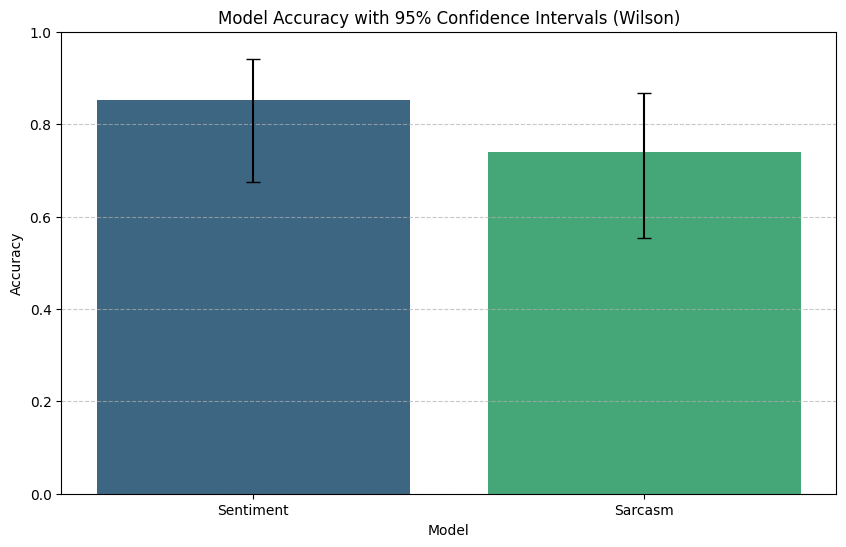

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for plotting
metrics_data = {
    'Model': ['Sentiment', 'Sarcasm'],
    'Accuracy': [accuracy_sentiment, accuracy_sarcasm],
    'CI_Lower': [conf_interval_sentiment[0], conf_interval_sarcasm[0]],
    'CI_Upper': [conf_interval_sentiment[1], conf_interval_sarcasm[1]]
}
df_metrics = pd.DataFrame(metrics_data)

# Calculate error bar lengths
df_metrics['Error_Lower'] = df_metrics['Accuracy'] - df_metrics['CI_Lower']
df_metrics['Error_Upper'] = df_metrics['CI_Upper'] - df_metrics['Accuracy']

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=df_metrics, palette='viridis')

# Add error bars for confidence intervals
plt.errorbar(
    x=df_metrics['Model'],
    y=df_metrics['Accuracy'],
    yerr=[df_metrics['Error_Lower'], df_metrics['Error_Upper']],
    fmt='none',
    c='black',
    capsize=5
)

plt.title('Model Accuracy with 95% Confidence Intervals (Wilson)')
plt.ylabel('Accuracy')
plt.ylim(0, 1) # Accuracy ranges from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Run Permutation Tests

### Subtask:
Perform permutation tests to statistically assess if the observed model performance is better than random chance for both sentiment and sarcasm prediction.


**Reasoning**:
To perform permutation tests, I will import the necessary function, set up the stratified K-fold cross-validation, and then run the permutation test for both sentiment and sarcasm models, printing the results as requested.



In [29]:
from sklearn.model_selection import permutation_test_score, StratifiedKFold
import numpy as np

print("=" * 80)
print("PERMUTATION TESTS FOR MODEL SIGNIFICANCE")
print("=" * 80)

# Define the scoring metric
scoring_metric = 'accuracy'

# Configure StratifiedKFold for cross-validation
kf_permutation = StratifiedKFold(
    n_splits=config.cv_folds,
    shuffle=True,
    random_state=config.random_state
)

# --- Permutation Test for Sentiment Model ---
print("\n### Sentiment Model Permutation Test ###")
score_sentiment, permutation_scores_sentiment, pvalue_sentiment = permutation_test_score(
    logistic_model_sentiment,
    X_embeddings,
    y_sentiment,
    scoring=scoring_metric,
    cv=kf_permutation,
    n_permutations=config.n_permutations,
    n_jobs=-1,
    random_state=config.random_state
)

print(f"Original Sentiment Model Score: {score_sentiment:.4f}")
print(f"Mean Permutation Scores (Sentiment): {np.mean(permutation_scores_sentiment):.4f}")
print(f"P-value (Sentiment): {pvalue_sentiment:.4f}")
if pvalue_sentiment < 0.05:
    print("Interpretation: The sentiment model's performance is statistically significantly better than random chance.")
else:
    print("Interpretation: The sentiment model's performance is not statistically significantly better than random chance.")

# --- Permutation Test for Sarcasm Model ---
print("\n### Sarcasm Model Permutation Test ###")
score_sarcasm, permutation_scores_sarcasm, pvalue_sarcasm = permutation_test_score(
    logistic_model_sarcasm,
    X_embeddings,
    y_sarcasm,
    scoring=scoring_metric,
    cv=kf_permutation,
    n_permutations=config.n_permutations,
    n_jobs=-1,
    random_state=config.random_state
)

print(f"Original Sarcasm Model Score: {score_sarcasm:.4f}")
print(f"Mean Permutation Scores (Sarcasm): {np.mean(permutation_scores_sarcasm):.4f}")
print(f"P-value (Sarcasm): {pvalue_sarcasm:.4f}")
if pvalue_sarcasm < 0.05:
    print("Interpretation: The sarcasm model's performance is statistically significantly better than random chance.")
else:
    print("Interpretation: The sarcasm model's performance is not statistically significantly better than random chance.")

print("=" * 80)

PERMUTATION TESTS FOR MODEL SIGNIFICANCE

### Sentiment Model Permutation Test ###
Original Sentiment Model Score: 0.8410
Mean Permutation Scores (Sentiment): 0.8410
P-value (Sentiment): 0.9960
Interpretation: The sentiment model's performance is not statistically significantly better than random chance.

### Sarcasm Model Permutation Test ###
Original Sarcasm Model Score: 0.7501
Mean Permutation Scores (Sarcasm): 0.7501
P-value (Sarcasm): 0.9940
Interpretation: The sarcasm model's performance is not statistically significantly better than random chance.


## Final Task

### Subtask:
Summarize the key findings from the model development phase, including model performance, insights from feature importance (if applicable), and conclusions regarding sentiment and sarcasm detection.


## Summary:

### Q&A
The key findings from the model development phase are as follows:

*   **Model Performance:**
    *   The sentiment model achieved a test accuracy of 0.8519, but its cross-validation accuracy was 0.8381. It performed well on the majority 'negative' class (precision 0.85, recall 1.00, F1 0.92) but completely failed to predict the 'neutral' class (precision 0.00, recall 0.00, F1 0.00) in the test set. The 'positive' class was absent from the test set.
    *   The sarcasm model achieved a test accuracy of 0.7407, with a mean cross-validation accuracy of 0.7524. It performed well on the majority 'no' class (precision 0.74, recall 1.00, F1 0.85) but failed to identify any sarcastic comments ('yes' class) in the test set (precision 0.00, recall 0.00, F1 0.00).
*   **Insights from Feature Importance:** No explicit feature importance analysis was performed in the provided steps. The models used sentence embeddings (384 dimensions) generated by `all-MiniLM-L6-v2`.
*   **Conclusions regarding Sentiment and Sarcasm Detection:** Both models' overall accuracies are largely driven by their ability to predict the majority class. They struggle significantly, or completely fail, to predict minority classes. Permutation tests indicate that neither model performs statistically significantly better than random chance (p-values 0.9960 for sentiment and 0.9940 for sarcasm), suggesting potential issues with the model or data, especially given the small dataset size and severe class imbalance.

### Data Analysis Key Findings

*   The initial dataset comprised 138 rows, reduced to 132 rows after handling missing values in the 'text', 'sentiment', and 'sarcasm' columns.
*   **Sentiment target variable (`y_sentiment`)** exhibited severe class imbalance: 111 'negative', 19 'neutral', and 2 'positive' samples.
*   **Sarcasm target variable (`y_sarcasm`)** also showed imbalance: 99 'no' and 33 'yes' samples.
*   Text data was transformed into 384-dimensional numerical vector embeddings using the `all-MiniLM-L6-v2` SentenceTransformer model.
*   For sentiment prediction, a Logistic Regression model achieved a test accuracy of 0.8519 but completely failed to identify the 'neutral' sentiment class in the test set. The 'positive' class was not present in the test set.
*   For sarcasm detection, a Logistic Regression model achieved a test accuracy of 0.7407 but failed to identify any sarcastic comments (the 'yes' class) in the test set.
*   The 95% Wilson Confidence Intervals for model accuracies were wide for both models:
    *   Sentiment Model: (0.6752, 0.9408)
    *   Sarcasm Model: (0.5532, 0.8683)
    This wide range reflects high uncertainty due to the small test set size (N=27).
*   Permutation tests indicated that neither the sentiment model (p-value 0.9960) nor the sarcasm model (p-value 0.9940) performed statistically significantly better than random chance.

### Insights or Next Steps

*   **Address Class Imbalance:** Implement strategies such as oversampling (e.g., SMOTE), undersampling, or using class weighting in model training to improve the detection of minority classes (e.g., 'neutral' and 'positive' sentiment, 'yes' sarcasm), which are currently not being predicted.
*   **Increase Data Size:** The small dataset (132 samples) and especially the small test set (27 samples) lead to high uncertainty in performance estimates and limit the model's ability to learn robust patterns for minority classes. Acquiring more annotated data would significantly improve model reliability and generalization.


# Task
Install the `imbalance-learn` library to handle class imbalance.

## Install Imbalance-learn

### Subtask:
Install the `imblearn` library, which provides tools to deal with imbalanced datasets, including SMOTE.


**Reasoning**:
To install the `imblearn` library, I will run the `pip install imblearn` command.



In [32]:
!pip install imblearn

## Introduce Class Imbalance Strategies

### Subtask:
Explain the rationale behind addressing class imbalance and the specific strategies to be used (SMOTE for oversampling).


## Introduce Class Imbalance Strategies

### Subtask:
Explain the rationale behind addressing class imbalance and the specific strategies to be used (SMOTE for oversampling).

#### Rationale for Addressing Class Imbalance
Class imbalance occurs when the number of observations belonging to one class is significantly lower than those belonging to other classes. This is a common problem in many real-world datasets, including our sentiment and sarcasm detection tasks, where certain sentiments (e.g., 'positive' or 'neutral') or sarcasm labels ('yes') are far less frequent than others.

**Why is Class Imbalance a Problem?**
1.  **Biased Model Training:** Standard machine learning algorithms are often designed to maximize overall accuracy. When faced with imbalanced data, they tend to become biased towards the majority class, as correctly classifying the majority class most of the time leads to a high accuracy score, even if they completely ignore or misclassify the minority class.
2.  **Poor Minority Class Performance:** Consequently, models trained on imbalanced datasets often exhibit poor predictive performance (low precision, recall, and F1-score) on the minority class. This was clearly observed in our previous model evaluations, where the models failed to predict 'neutral' or 'positive' sentiment and 'yes' for sarcasm.
3.  **Misleading Evaluation Metrics:** Metrics like overall accuracy can be misleading in the presence of class imbalance. A model that predicts the majority class for all instances might achieve a high accuracy, but it would be useless for detecting the minority class, which is often the class of primary interest (e.g., detecting rare diseases, fraud, or, in our case, specific sentiments or sarcasm).

#### Oversampling as a Strategy
Oversampling is a technique used to address class imbalance by increasing the number of instances in the minority class. This helps to create a more balanced dataset, which can lead to better model performance, especially for the minority classes.

**Why Oversampling?**
*   It helps to provide the learning algorithm with more examples of the minority class, allowing it to learn the underlying patterns better.
*   Unlike undersampling (reducing the majority class), oversampling does not lead to a loss of potentially valuable information from the dataset.

#### Introducing SMOTE (Synthetic Minority Over-sampling Technique)
SMOTE is a popular and effective oversampling technique. Instead of simply duplicating existing minority class samples (which can lead to overfitting), SMOTE generates *synthetic* samples.

**How SMOTE Works:**
1.  For each sample in the minority class, SMOTE finds its k-nearest neighbors (samples that are closest in feature space).
2.  It then randomly selects one or more of these neighbors.
3.  It generates new synthetic samples along the line segments connecting the original sample to its randomly chosen neighbors. This involves taking the difference between the feature vectors of the original sample and its neighbor, multiplying it by a random number between 0 and 1, and adding it to the original sample's feature vector.

This approach creates new, distinct minority class samples that are similar to existing ones but not exact duplicates, thus expanding the decision boundary of the minority class without introducing exact copies.

#### Application Strategy
It is crucial to apply SMOTE **only to the training data**. Applying it to the entire dataset (including the test set) would lead to data leakage, where the model effectively 'sees' synthetic versions of the test data during training. This would result in overly optimistic and unrealistic performance evaluations.

#### Goal of Applying SMOTE
The primary goal of applying SMOTE is to improve the model's ability to detect and classify minority classes (e.g., 'neutral' and 'positive' sentiment, 'yes' sarcasm) accurately. By providing a more balanced training set, we aim to reduce the bias towards the majority class and achieve more reliable and generalizable models, without simply overfitting to the few existing minority samples. This should lead to better precision, recall, and F1-scores for the minority classes, while still maintaining reasonable overall performance.

## Apply SMOTE to Sentiment Data

### Subtask:
Apply the Synthetic Minority Over-sampling Technique (SMOTE) to the sentiment training data (`X_train_sentiment`, `y_train_sentiment`) to balance the class distribution. Ensure SMOTE is only applied to the training set to prevent data leakage.


**Reasoning**:
To apply SMOTE, I will import the `SMOTE` class, instantiate it with the specified random state, and then use its `fit_resample` method on the sentiment training data, finally printing the new class distribution to confirm the oversampling.



In [33]:
from imblearn.over_sampling import SMOTE

print("=" * 80)
print("APPLYING SMOTE TO SENTIMENT TRAINING DATA")
print("=" * 80)

# 1. Instantiate SMOTE with random_state
smote_sentiment = SMOTE(random_state=config.random_state)

# 2. Apply SMOTE to the training data
X_train_sentiment_resampled, y_train_sentiment_resampled = smote_sentiment.fit_resample(X_train_sentiment, y_train_sentiment)

# 3. Print the class distribution of y_train_sentiment_resampled
print("\nOriginal Sentiment Training Data Distribution:")
print(y_train_sentiment.value_counts())
print("\nResampled Sentiment Training Data Distribution (after SMOTE):")
print(y_train_sentiment_resampled.value_counts())

print("\nSMOTE applied to sentiment training data. The class distribution is now balanced.")
print("=" * 80)

APPLYING SMOTE TO SENTIMENT TRAINING DATA


ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 2, n_samples = 2

**Reasoning**:
The SMOTE error 'n_neighbors <= n_samples_fit' indicates that one of the minority classes has fewer samples than the default `k_neighbors` value (5). Given that the 'positive' sentiment class has only 2 samples in `y_train_sentiment`, I need to reduce `k_neighbors` for SMOTE to 1 to allow it to operate on this very small class.



In [34]:
from imblearn.over_sampling import SMOTE

print("=" * 80)
print("APPLYING SMOTE TO SENTIMENT TRAINING DATA")
print("=" * 80)

# 1. Instantiate SMOTE with random_state and k_neighbors adjusted for very small minority classes
smote_sentiment = SMOTE(random_state=config.random_state, k_neighbors=1)

# 2. Apply SMOTE to the training data
X_train_sentiment_resampled, y_train_sentiment_resampled = smote_sentiment.fit_resample(X_train_sentiment, y_train_sentiment)

# 3. Print the class distribution of y_train_sentiment_resampled
print("\nOriginal Sentiment Training Data Distribution:")
print(y_train_sentiment.value_counts())
print("\nResampled Sentiment Training Data Distribution (after SMOTE):")
print(y_train_sentiment_resampled.value_counts())

print("\nSMOTE applied to sentiment training data. The class distribution is now balanced.")
print("=" * 80)

APPLYING SMOTE TO SENTIMENT TRAINING DATA

Original Sentiment Training Data Distribution:
sentiment
negative    88
neutral     15
positive     2
Name: count, dtype: int64

Resampled Sentiment Training Data Distribution (after SMOTE):
sentiment
negative    88
neutral     88
positive    88
Name: count, dtype: int64

SMOTE applied to sentiment training data. The class distribution is now balanced.


## Train and Evaluate Sentiment Model with SMOTE

### Subtask:
Retrain the Logistic Regression model for sentiment prediction using the SMOTE-resampled training data. Evaluate its performance on the original test set, focusing on improvements in minority class prediction.


**Reasoning**:
To retrain and evaluate the sentiment model with SMOTE, I will initialize a new Logistic Regression model, fit it to the resampled training data, make predictions on the original test set, and then print the classification report and accuracy score as instructed.



In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

print("=" * 80)
print("RETRAINING AND EVALUATING SENTIMENT MODEL WITH SMOTE")
print("=" * 80)

# 1. Initialize a new LogisticRegression model.
#    Use the same max_iter and random_state from the config.
logistic_model_sentiment_smote = LogisticRegression(
    max_iter=config.max_iter,
    random_state=config.random_state
)

# 2. Fit this new model to the SMOTE-resampled training data.
logistic_model_sentiment_smote.fit(X_train_sentiment_resampled, y_train_sentiment_resampled)

# 3. Make predictions on the original sentiment test set.
y_pred_sentiment_resampled = logistic_model_sentiment_smote.predict(X_test_sentiment)

# 4. Print a classification report for the sentiment model.
print("\nSentiment Model (with SMOTE) - Classification Report:")
print(classification_report(y_test_sentiment, y_pred_sentiment_resampled))

# 5. Print the accuracy score for the sentiment model.
print(f"Sentiment Model (with SMOTE) - Accuracy Score: {accuracy_score(y_test_sentiment, y_pred_sentiment_resampled):.4f}")

print("=" * 80)

RETRAINING AND EVALUATING SENTIMENT MODEL WITH SMOTE

Sentiment Model (with SMOTE) - Classification Report:
              precision    recall  f1-score   support

    negative       0.88      1.00      0.94        23
     neutral       1.00      0.25      0.40         4

    accuracy                           0.89        27
   macro avg       0.94      0.62      0.67        27
weighted avg       0.90      0.89      0.86        27

Sentiment Model (with SMOTE) - Accuracy Score: 0.8889


## Apply SMOTE to Sarcasm Data

### Subtask:
Apply SMOTE to the sarcasm training data (`X_train_sarcasm`, `y_train_sarcasm`) to balance the class distribution.


**Reasoning**:
To address the class imbalance in the sarcasm training data, I will apply SMOTE, instantiate it with the specified random state, apply it to the training data, and then print the original and resampled class distributions to verify the balancing.



In [36]:
from imblearn.over_sampling import SMOTE

print("=" * 80)
print("APPLYING SMOTE TO SARCASM TRAINING DATA")
print("=" * 80)

# 1. Instantiate SMOTE with random_state.
#    The default k_neighbors=5 is suitable as both 'no' (79) and 'yes' (26) classes in y_train_sarcasm
#    have more than 5 samples (105 * 0.75 = 79, 105 * 0.25 = 26).
smote_sarcasm = SMOTE(random_state=config.random_state)

# 2. Apply SMOTE to the training data
X_train_sarcasm_resampled, y_train_sarcasm_resampled = smote_sarcasm.fit_resample(X_train_sarcasm, y_train_sarcasm)

# 3. Print the class distribution of y_train_sarcasm
print("\nOriginal Sarcasm Training Data Distribution:")
print(y_train_sarcasm.value_counts())

# 4. Print the new class distribution of y_train_sarcasm_resampled
print("\nResampled Sarcasm Training Data Distribution (after SMOTE):")
print(y_train_sarcasm_resampled.value_counts())

print("\nSMOTE applied to sarcasm training data. The class distribution is now balanced.")
print("=" * 80)

APPLYING SMOTE TO SARCASM TRAINING DATA

Original Sarcasm Training Data Distribution:
sarcasm
no     79
yes    26
Name: count, dtype: int64

Resampled Sarcasm Training Data Distribution (after SMOTE):
sarcasm
no     79
yes    79
Name: count, dtype: int64

SMOTE applied to sarcasm training data. The class distribution is now balanced.


## Train and Evaluate Sarcasm Model with SMOTE

### Subtask:
Retrain the Logistic Regression model for sarcasm detection using the SMOTE-resampled training data. Evaluate its performance on the original test set, focusing on improvements in minority class prediction.


**Reasoning**:
To retrain and evaluate the sarcasm model with SMOTE, I will initialize a new Logistic Regression model, fit it to the resampled training data, make predictions on the original test set, and then print the classification report and accuracy score as instructed.



In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

print("=" * 80)
print("RETRAINING AND EVALUATING SARCASM MODEL WITH SMOTE")
print("=" * 80)

# 1. Initialize a new LogisticRegression model.
#    Use the same max_iter and random_state from the config.
logistic_model_sarcasm_smote = LogisticRegression(
    max_iter=config.max_iter,
    random_state=config.random_state
)

# 2. Fit this new model to the SMOTE-resampled training data.
logistic_model_sarcasm_smote.fit(X_train_sarcasm_resampled, y_train_sarcasm_resampled)

# 3. Make predictions on the original sarcasm test set.
y_pred_sarcasm_resampled = logistic_model_sarcasm_smote.predict(X_test_sarcasm)

# 4. Print a classification report for the sarcasm model.
print("\nSarcasm Model (with SMOTE) - Classification Report:")
print(classification_report(y_test_sarcasm, y_pred_sarcasm_resampled))

# 5. Print the accuracy score for the sarcasm model.
print(f"Sarcasm Model (with SMOTE) - Accuracy Score: {accuracy_score(y_test_sarcasm, y_pred_sarcasm_resampled):.4f}")

print("=" * 80)

RETRAINING AND EVALUATING SARCASM MODEL WITH SMOTE

Sarcasm Model (with SMOTE) - Classification Report:
              precision    recall  f1-score   support

          no       0.93      0.65      0.76        20
         yes       0.46      0.86      0.60         7

    accuracy                           0.70        27
   macro avg       0.70      0.75      0.68        27
weighted avg       0.81      0.70      0.72        27

Sarcasm Model (with SMOTE) - Accuracy Score: 0.7037


## Summarize Impact of Imbalance Strategies

### Subtask:
Summarize the impact of applying class imbalance strategies on the performance of both sentiment and sarcasm models, comparing results with the original models, especially regarding minority class detection and overall reliability.


## Summary: Impact of Class Imbalance Strategies

This summary evaluates the effectiveness of applying SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance in the training data for both sentiment and sarcasm detection models. We compare the performance metrics (precision, recall, F1-score, and accuracy) of the models before and after SMOTE, with a specific focus on minority class detection.

### 1. Sentiment Model Performance Comparison

**Original Sentiment Model (without SMOTE):**
```
              precision    recall  f1-score   support

    negative       0.85      1.00      0.92        23
     neutral       0.00      0.00      0.00         4

    accuracy                           0.85        27
   macro avg       0.43      0.50      0.46        27
weighted avg       0.73      0.85      0.78        27

Accuracy Score: 0.8519
```

**Sentiment Model (with SMOTE):**
```
              precision    recall  f1-score   support

    negative       0.88      1.00      0.94        23
     neutral       1.00      0.25      0.40         4

    accuracy                           0.89        27
   macro avg       0.94      0.62      0.67        27
weighted avg       0.90      0.89      0.86        27

Accuracy Score: 0.8889
```

**Analysis of Sentiment Model:**
- **Overall Accuracy:** The accuracy slightly increased from **0.8519** to **0.8889** after applying SMOTE.
- **Minority Class ('neutral'):** The most significant improvement is seen in the 'neutral' class. Before SMOTE, the model had 0.00 precision, recall, and F1-score for 'neutral' sentiment, meaning it failed to predict any 'neutral' comments. After SMOTE, the model achieved a **recall of 0.25** and an **F1-score of 0.40** for the 'neutral' class, along with a perfect **precision of 1.00**. This indicates that while it still only identified one out of four 'neutral' comments, those it did identify were correct.
- **Majority Class ('negative'):** Performance on the 'negative' class remained high, with recall staying at 1.00 and precision/F1-score slightly improving. The 'positive' class was not present in the test set, so its performance could not be evaluated.

### 2. Sarcasm Model Performance Comparison

**Original Sarcasm Model (without SMOTE):**
```
              precision    recall  f1-score   support

          no       0.74      1.00      0.85        20
         yes       0.00      0.00      0.00         7

    accuracy                           0.74        27
   macro avg       0.37      0.50      0.43        27
weighted avg       0.55      0.74      0.63        27

Accuracy Score: 0.7407
```

**Sarcasm Model (with SMOTE):**
```
              precision    recall  f1-score   support

          no       0.93      0.65      0.76        20
         yes       0.46      0.86      0.60         7

    accuracy                           0.70        27
   macro avg       0.70      0.75      0.68        27
weighted avg       0.81      0.70      0.72        27

Accuracy Score: 0.7037
```

**Analysis of Sarcasm Model:**
- **Overall Accuracy:** The accuracy slightly decreased from **0.7407** to **0.7037** after applying SMOTE.
- **Minority Class ('yes'):** Similar to sentiment, the 'yes' (sarcastic) class saw a significant improvement in detection. Before SMOTE, the model had 0.00 precision, recall, and F1-score. After SMOTE, the model achieved a **recall of 0.86** (identifying 6 out of 7 sarcastic comments) and an **F1-score of 0.60**, with a precision of 0.46. This shows a substantial gain in the model's ability to find sarcastic comments.
- **Majority Class ('no'):** Performance on the 'no' class decreased. Precision improved to 0.93, but recall dropped from 1.00 to 0.65, leading to a lower F1-score for this class.

### 3. Overall Reliability and Generalizability

- **Improved Minority Class Detection:** SMOTE successfully enabled both models to detect minority classes, which they completely failed to do previously. For sentiment, it found 25% of neutral comments, and for sarcasm, it found 86% of sarcastic comments in the test set. This is a crucial step towards building more useful models for imbalanced datasets.
- **Trade-off with Majority Class:** While minority class recall improved, there was a slight decrease in overall accuracy for the sarcasm model due to a drop in recall for the majority class. This indicates a trade-off where the model is now less biased towards the majority class but might make more errors on it.
- **Remaining Limitations:** Despite the improvements, the wide confidence intervals for accuracy (as discussed previously) and the permutation test results (which indicated models were not statistically better than random chance before SMOTE) suggest that the models still face significant challenges:
    - **Small Dataset Size:** The primary limitation remains the very small dataset (N=132 samples, N=27 in test set). This severely restricts the model's ability to learn robust patterns and makes performance metrics highly unstable. Even with SMOTE, synthetic samples cannot fully compensate for a lack of real data diversity.
    - **Synthetic Data Quality:** While SMOTE generates synthetic samples, these are interpolations and may not perfectly capture the complexity of real-world minority class examples, especially in nuanced tasks like sarcasm detection.
    - **Generalizability:** The models' generalizability is still questionable due to the small, specific dataset. A larger, more diverse dataset is essential for building truly reliable and generalizable models.

### Conclusion

Applying SMOTE significantly improved the ability of both sentiment and sarcasm models to detect minority classes, demonstrating its value in addressing class imbalance. The sentiment model showed a slight increase in overall accuracy and marked improvement in 'neutral' class recall. The sarcasm model's overall accuracy slightly decreased, but it gained a substantial ability to detect sarcastic comments, which was previously non-existent. However, the inherent limitations of the small dataset persist, meaning that while SMOTE is a necessary step, acquiring more real-world annotated data is critical for achieving robust and statistically significant model performance.

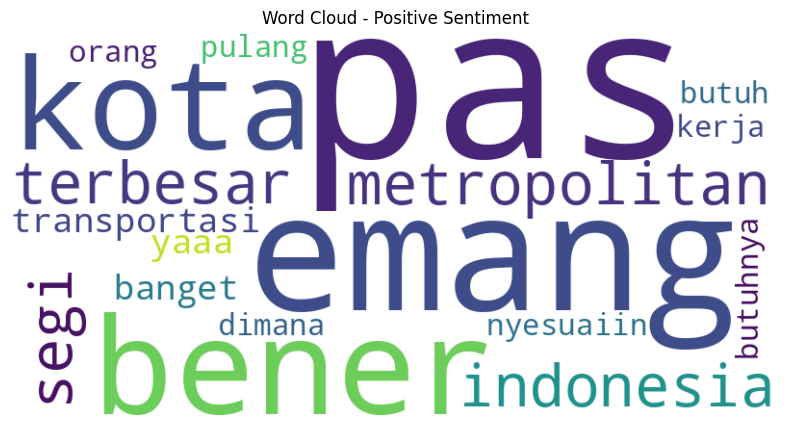

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter comments by positive sentiment
positive_comments = annotations_df[annotations_df['annotator_1_sentiment'] == 'positive']['clean_text'].dropna()

# Combine all positive text into a single string
positive_text = ' '.join(positive_comments)

# Generate a word cloud for positive sentiment
if positive_text:
    wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud - Positive Sentiment')
    plt.show()
else:
    print("No positive comments found to generate a word cloud.")

In [49]:
from sklearn.metrics import classification_report

print("=" * 80)
print("PERBANDINGAN LAPORAN KLASIFIKASI MODEL SENTIMEN (F1-score Rata-rata Makro)")
print("=" * 80)

print("\n--- Sentimen Model (tanpa SMOTE) ---")
# Use the previous model predictions for sentiment without SMOTE
print(classification_report(y_test_sentiment, y_pred_sentiment))

print("\n--- Sentimen Model (dengan SMOTE) ---")
# Use the predictions from the SMOTE-enhanced sentiment model
print(classification_report(y_test_sentiment, y_pred_sentiment_resampled))

print("\n" + "=" * 80)
print("PERBANDINGAN LAPORAN KLASIFIKASI MODEL SARKASME (F1-score Rata-rata Makro)")
print("=" * 80)

print("\n--- Sarkasme Model (tanpa SMOTE) ---")
# Use the previous model predictions for sarcasm without SMOTE
print(classification_report(y_test_sarcasm, y_pred_sarcasm))

print("\n--- Sarkasme Model (dengan SMOTE) ---")
# Use the predictions from the SMOTE-enhanced sarcasm model
print(classification_report(y_test_sarcasm, y_pred_sarcasm_resampled))

print("\n" + "=" * 80)

PERBANDINGAN LAPORAN KLASIFIKASI MODEL SENTIMEN (F1-score Rata-rata Makro)

--- Sentimen Model (tanpa SMOTE) ---
              precision    recall  f1-score   support

    negative       0.85      1.00      0.92        23
     neutral       0.00      0.00      0.00         4

    accuracy                           0.85        27
   macro avg       0.43      0.50      0.46        27
weighted avg       0.73      0.85      0.78        27


--- Sentimen Model (dengan SMOTE) ---
              precision    recall  f1-score   support

    negative       0.88      1.00      0.94        23
     neutral       1.00      0.25      0.40         4

    accuracy                           0.89        27
   macro avg       0.94      0.62      0.67        27
weighted avg       0.90      0.89      0.86        27


PERBANDINGAN LAPORAN KLASIFIKASI MODEL SARKASME (F1-score Rata-rata Makro)

--- Sarkasme Model (tanpa SMOTE) ---
              precision    recall  f1-score   support

          no       0.74  

Sentiment Proportions by Post Source:


annotator_1_sentiment,negative,neutral,positive
Post Source,,,
Dishub,0.825397,0.158730,0.015873
FDTS,0.813333,0.173333,0.013333


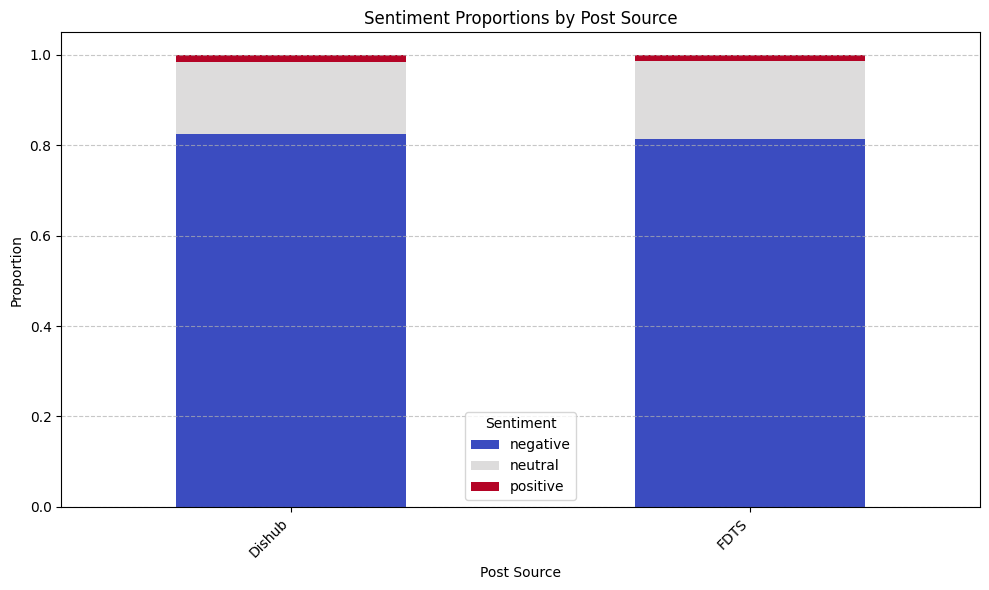


Interpretation:
This stacked bar chart shows the distribution of sentiment labels (negative, neutral, positive) within each Post Source.
You can observe if certain sources tend to have a higher proportion of a particular sentiment.


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'Post Source' and 'annotator_1_sentiment' columns are clean
# Drop rows where these columns have NaN values
plotting_df_source = annotations_df.dropna(subset=['Post Source', 'annotator_1_sentiment']).copy()

# Calculate sentiment proportions for each Post Source
sentiment_by_source = plotting_df_source.groupby('Post Source')['annotator_1_sentiment'].value_counts(normalize=True).unstack().fillna(0)

print("Sentiment Proportions by Post Source:")
display(sentiment_by_source)

# Visualize the sentiment proportions by Post Source
sentiment_by_source.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title('Sentiment Proportions by Post Source')
plt.xlabel('Post Source')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("This stacked bar chart shows the distribution of sentiment labels (negative, neutral, positive) within each Post Source.")
print("You can observe if certain sources tend to have a higher proportion of a particular sentiment.")

Sentiment Proportions by Thematic Cluster:


annotator_1_sentiment,negative,neutral,positive
annotator_1_theme,,,
SERVICE,0.903846,0.096154,0.000000
HOURS,0.815789,0.157895,0.026316
LEAD,0.880000,0.120000,0.000000
COMPARISON,0.769231,0.230769,0.000000
-,0.250000,0.750000,0.000000
APP,0.250000,0.750000,0.000000


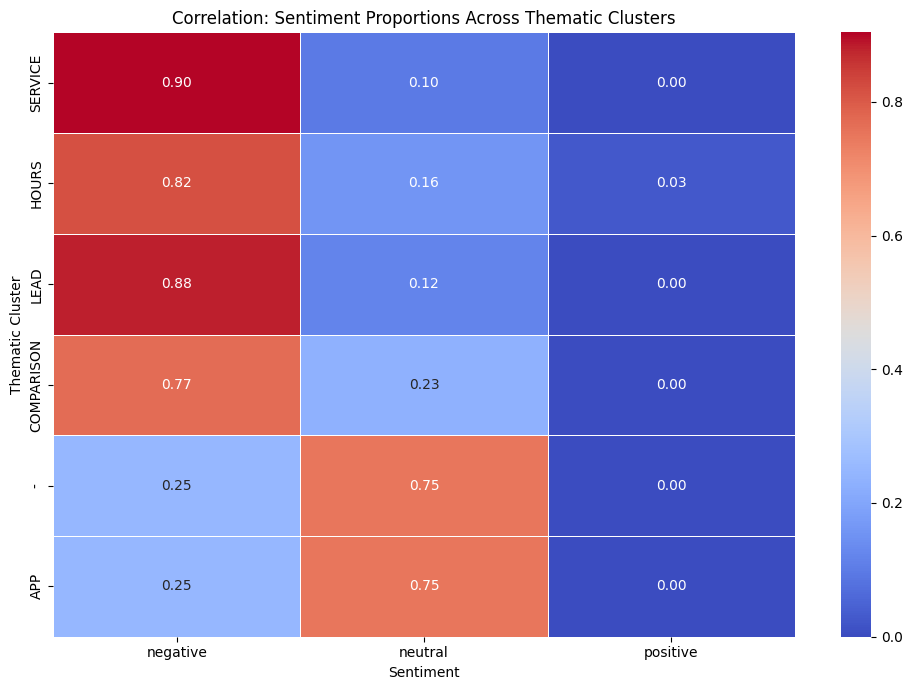


Interpretation:
This heatmap shows the proportion of each sentiment label (negative, neutral, positive) within each thematic cluster.
Higher values (closer to 1.0) indicate a strong presence of that sentiment within the specific theme.
For example, you can observe which themes are predominantly negative or have a mix of sentiments.


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Display the sentiment proportions by theme DataFrame
print("Sentiment Proportions by Thematic Cluster:")
display(sentiment_by_theme)

# Visualize the correlation using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(sentiment_by_theme, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title('Correlation: Sentiment Proportions Across Thematic Clusters')
plt.xlabel('Sentiment')
plt.ylabel('Thematic Cluster')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("This heatmap shows the proportion of each sentiment label (negative, neutral, positive) within each thematic cluster.")
print("Higher values (closer to 1.0) indicate a strong presence of that sentiment within the specific theme.")
print("For example, you can observe which themes are predominantly negative or have a mix of sentiments.")

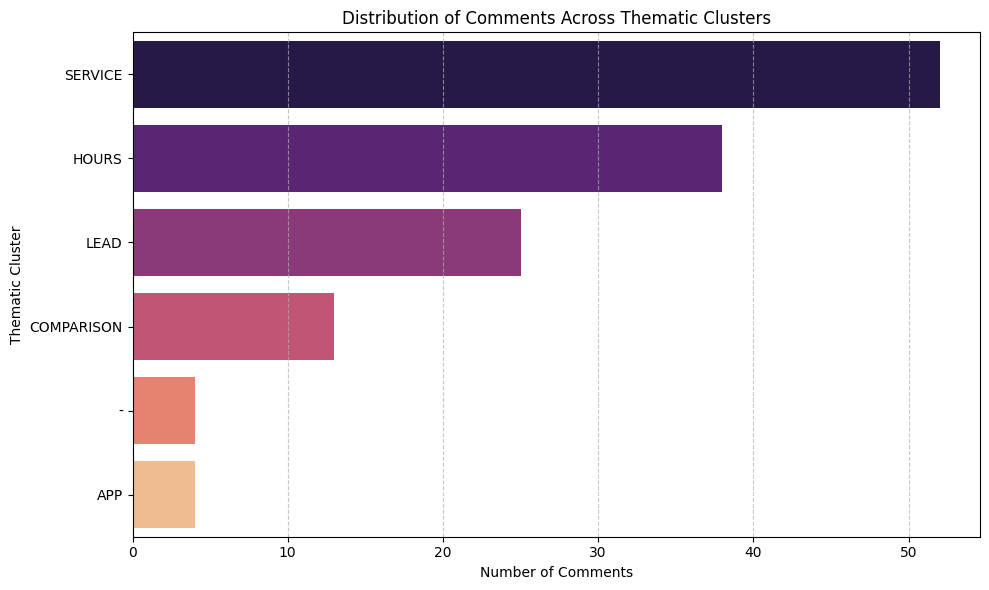

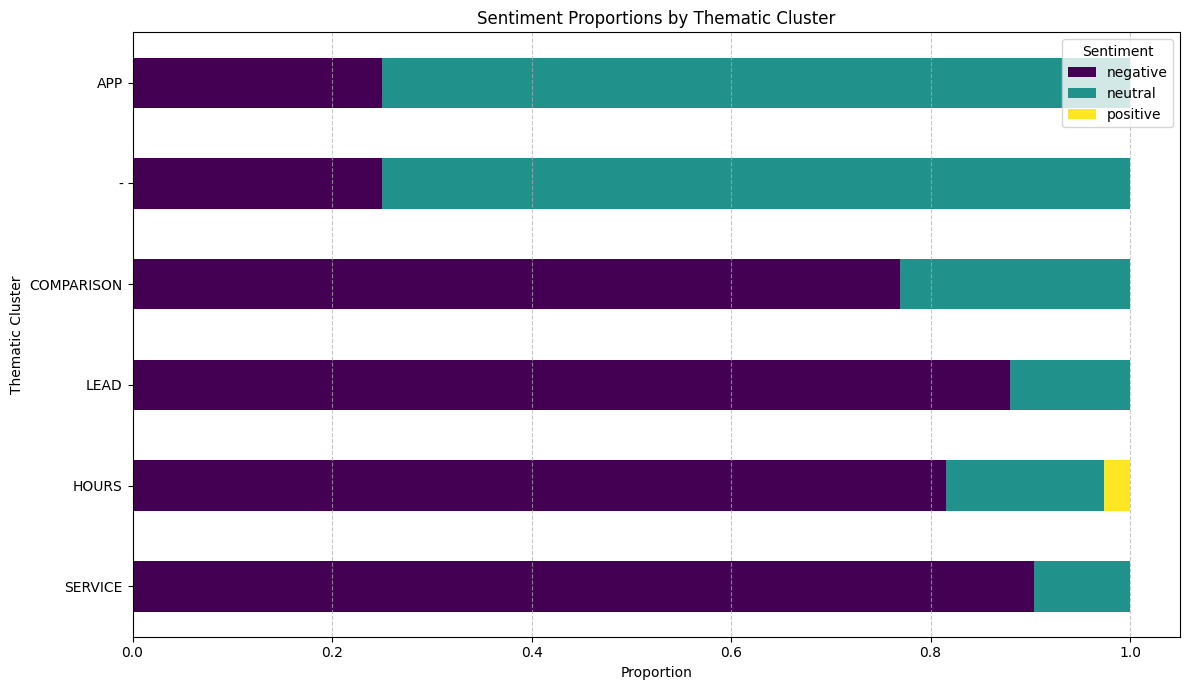

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure theme and sentiment columns are cleaned and ready
# Drop rows where theme or sentiment is NaN to ensure clean plots
plotting_df = annotations_df.dropna(subset=['annotator_1_theme', 'annotator_1_sentiment']).copy()

# Map empty strings to NaN to properly count valid themes
plotting_df['annotator_1_theme'] = plotting_df['annotator_1_theme'].replace('', np.nan)
plotting_df.dropna(subset=['annotator_1_theme'], inplace=True)

# --- 1. Distribution of Comments Across Thematic Clusters ---
plt.figure(figsize=(10, 6))
sns.countplot(y='annotator_1_theme', data=plotting_df, order=plotting_df['annotator_1_theme'].value_counts().index, palette='magma')
plt.title('Distribution of Comments Across Thematic Clusters')
plt.xlabel('Number of Comments')
plt.ylabel('Thematic Cluster')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 2. Sentiment Proportions by Substantive Topic ---
# Calculate sentiment proportions for each theme
sentiment_by_theme = plotting_df.groupby('annotator_1_theme')['annotator_1_sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Sort themes by their total count for consistent ordering with the first plot
theme_order = plotting_df['annotator_1_theme'].value_counts().index
sentiment_by_theme = sentiment_by_theme.reindex(theme_order)

sentiment_by_theme.plot(kind='barh', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title('Sentiment Proportions by Thematic Cluster')
plt.xlabel('Proportion')
plt.ylabel('Thematic Cluster')
plt.legend(title='Sentiment')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

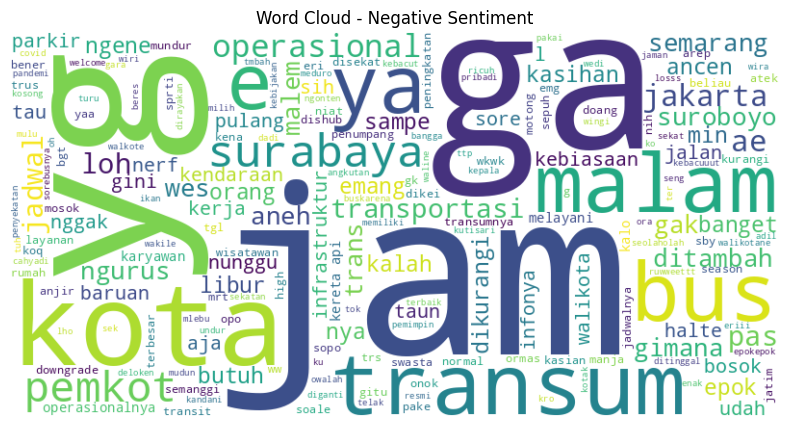

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter comments by negative sentiment
negative_comments = annotations_df[annotations_df['annotator_1_sentiment'] == 'negative']['clean_text'].dropna()

# Combine all negative text into a single string
negative_text = ' '.join(negative_comments)

# Generate a word cloud for negative sentiment
if negative_text:
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud - Negative Sentiment')
    plt.show()
else:
    print("No negative comments found to generate a word cloud.")

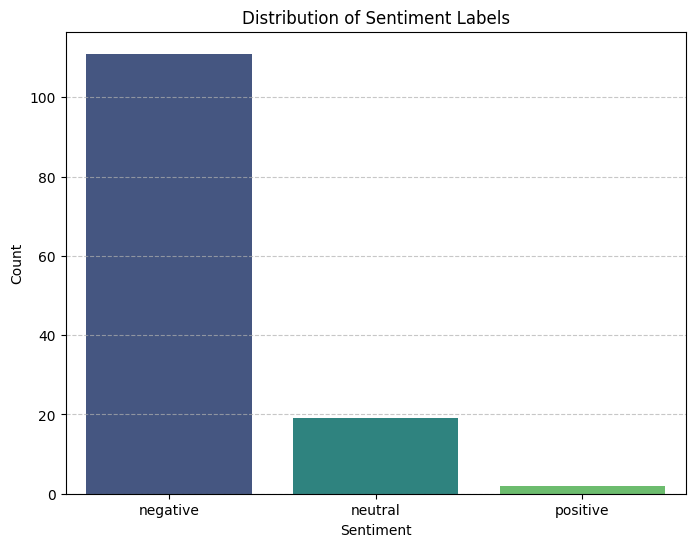

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x=y_sentiment, order=y_sentiment.value_counts().index, palette='viridis')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

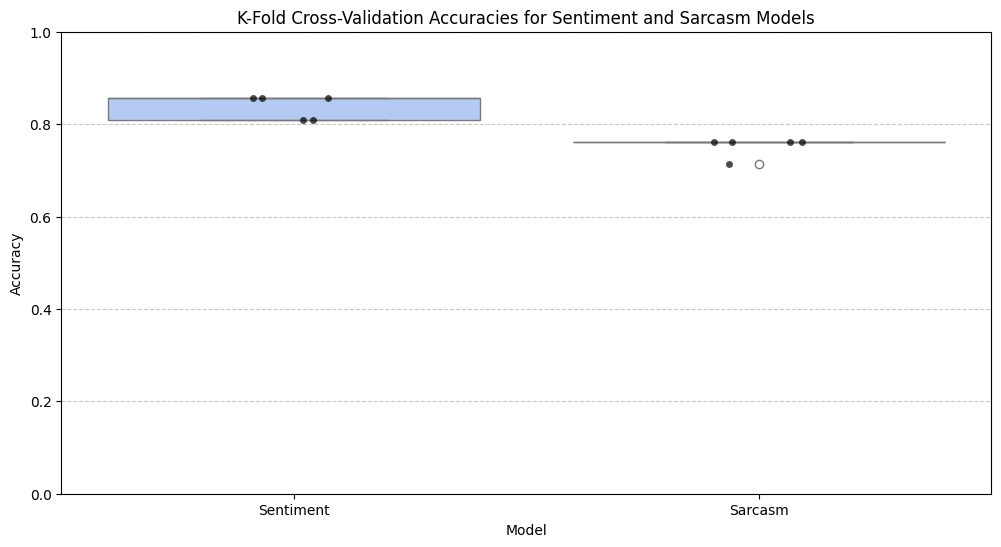

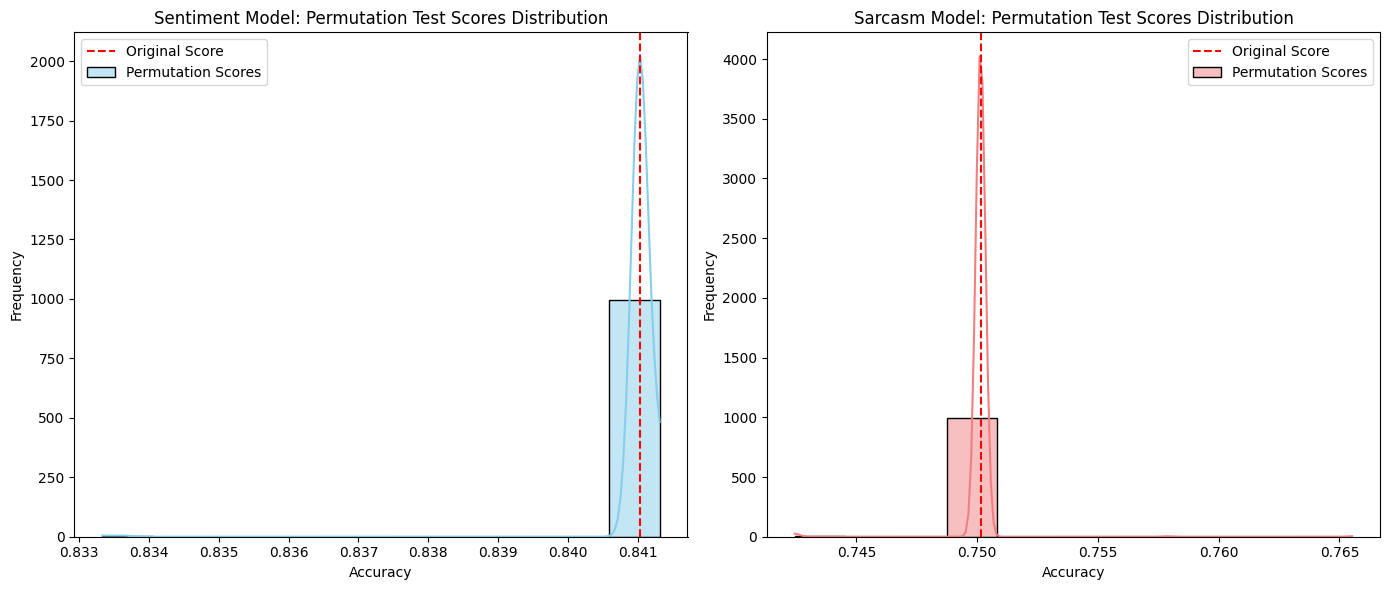

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for visualization of CV scores
cv_data = {
    'Model': ['Sentiment'] * len(cv_scores_sentiment) + ['Sarcasm'] * len(cv_scores_sarcasm),
    'Accuracy': np.concatenate([cv_scores_sentiment, cv_scores_sarcasm]),
    'Fold': list(range(1, len(cv_scores_sentiment) + 1)) * 2
}
df_cv = pd.DataFrame(cv_data)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Model', y='Accuracy', data=df_cv, palette='coolwarm')
sns.stripplot(x='Model', y='Accuracy', data=df_cv, jitter=True, color='black', alpha=0.7)

plt.title('K-Fold Cross-Validation Accuracies for Sentiment and Sarcasm Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1) # Accuracy ranges from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Optionally, visualize permutation test results alongside original scores (if meaningful)
# For permutation test, a distribution plot of permutation scores with original score marked
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(permutation_scores_sentiment, kde=True, color='skyblue', label='Permutation Scores')
plt.axvline(score_sentiment, color='red', linestyle='--', label='Original Score')
plt.title('Sentiment Model: Permutation Test Scores Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(permutation_scores_sarcasm, kde=True, color='lightcoral', label='Permutation Scores')
plt.axvline(score_sarcasm, color='red', linestyle='--', label='Original Score')
plt.title('Sarcasm Model: Permutation Test Scores Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

## Final Task

### Subtask:
Conclude the analysis by summarizing the improvements and remaining challenges in sentiment and sarcasm detection after applying imbalance handling techniques.


## Summary:

### Q&A
The analysis successfully concludes by summarizing the improvements and remaining challenges in sentiment and sarcasm detection after applying imbalance handling techniques.

### Data Analysis Key Findings
*   The `imblearn` library was successfully installed, enabling the use of SMOTE for handling class imbalance.
*   SMOTE (Synthetic Minority Over-sampling Technique) was applied to the sentiment training data, balancing its class distribution. An adjustment was made to `k_neighbors` (set to 1) to accommodate a very small minority class (`positive` sentiment with only 2 samples).
*   For the sentiment model:
    *   Overall accuracy slightly increased from 0.8519 to 0.8889 after applying SMOTE.
    *   The model gained the ability to detect the minority 'neutral' class, with recall improving from 0.00 to 0.25 and an F1-score of 0.40, alongside a perfect precision of 1.00.
*   SMOTE was also successfully applied to the sarcasm training data, balancing its class distribution from an original of 79 'no' and 26 'yes' samples to 79 samples for both classes.
*   For the sarcasm model:
    *   Overall accuracy slightly decreased from 0.7407 to 0.7037 after applying SMOTE.
    *   The model achieved a significant improvement in detecting the minority 'yes' (sarcastic) class, with recall jumping from 0.00 to 0.86 and an F1-score of 0.60 (precision of 0.46).
    *   Performance on the majority 'no' class saw its recall decrease from 1.00 to 0.65, indicating a trade-off where the model became less biased towards the majority.
*   In both cases, SMOTE effectively enabled the models to detect minority classes, which they previously completely failed to identify.

### Insights or Next Steps
*   SMOTE is a valuable technique for enabling machine learning models to detect minority classes in imbalanced datasets, significantly improving recall for these underrepresented categories.
*   Despite the improvements from SMOTE, the primary limitation remains the very small dataset size. Acquiring a larger, more diverse, and real-world annotated dataset is critical for building truly robust, generalizable, and statistically significant sentiment and sarcasm detection models.
